# Import & Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings

In [3]:
pd.set_option('max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
PATH_TO_DATA = '../data/raw'

# Class for EDA

In [5]:
class Frame:
    def __init__(self, path_to_df, index_col=None, parse_dates=None, target=None):
        self._df = pd.read_csv(os.path.join(PATH_TO_DATA, path_to_df), index_col=index_col, parse_dates=parse_dates)
        self._target = target
        self._cat_features = []
        self._num_features = []
        self._bin_features = []
        self._init_feat_descriptors()
        
    def _init_feat_descriptors(self):
        self._cat_features = list(self.df.select_dtypes(include=['object']).columns)
        self._num_features = list(self.df.select_dtypes(exclude=['object']).columns)
        self._bin_features = list(self.df.columns[(self.df.nunique(axis=0) == 2)])
    
    @property
    def target(self):
        return self._target
    
    @property
    def df(self):
        return self._df
    
    @property
    def cat_features(self):
        return self._cat_features
    
    @property
    def num_features(self):
        return self._num_features
    
    @property
    def bin_features(self):
        return self._bin_features
    
    def count_NaN(self, display=True):
        if display:
            print(f'There are {self.df.isnull().any().sum()} columns in dataset ' + 
                  f'with missing values from {self.df.shape[1]}.')
            print("Number of NaNs for each object")
            print(self.df.isna().sum(axis=1), end="\n------------------------\n")
            print("Number of NaNs for each column")
            print(self.df.isna().sum(axis=0), end="\n------------------------\n")
        else:
            return self.df.isna().sum(axis=0)
                
    def count_unique(self, display=True):
        if display:
            for col in self.df.columns:
                qty_unq = len(self.df[col].unique())
                print(f"{col} has {qty_unq} unique values")
        else:
            return self.df.nunique(dropna = False)
    
    def info(self):
        return self.df.info()
    
    def describe(self, include=None):
        return self.df.describe(include=include)
    
    def shrink(self):
        for col in self.num_features:
            if str(self.df[col].dtype).startswith('float'):
                self.df[col] = pd.to_numeric(self.df[col], downcast='float', errors='ignore')
            elif str(self.df[col].dtype).startswith('date'):
                continue
            else:
                self.df[col] = pd.to_numeric(self.df[col], downcast='integer', errors='ignore')
                
    

In [6]:
class EDA:
    def __init__(self, frame):
        self._frame = frame
        
    @property
    def frame(self):
        return self._frame
    
    def numeric_plot(self, interactive=False, features=None):
            if features is None:
                features = self.frame.num_features
            elif isinstance(features, list):
                features = features
            else:
                return
            if not interactive:
                _, _ = plt.subplots(figsize=(16, 16))
                i = 1
                for feat in features:
                    rows = len(self.frame.num_features)
                    plt.subplot(rows, 2, i)
                    sns.distplot(self.frame.df[feat], bins=50)
                    plt.title(f'Distribution of {feat}');
                    plt.subplot(rows, 2, i + 1)
                    sns.violinplot(self.frame.df[feat])
                    plt.title(f'Violin of {feat}');
                    i += 2
                    print(self.frame.df[feat].value_counts().sort_values(ascending=False).head(10), end='\n\n')            
                
    def cat_plot(self, interactive=False, features=None):
        if features is None:
            features = self.frame.cat_features
        elif isinstance(features, list):
            features = features
        else:
            return
        if not interactive:
            _, _ = plt.subplots(figsize=(16, 16))
            for i, feat in enumerate(features):
                plt.subplot(len(features), 1, i + 1)
                g = sns.countplot(data=self.frame.df, x=feat)
                g.set_xticklabels(g.get_xticklabels(),rotation=90)
                plt.title(f'Distribution of {feat}');
                plt.subplots_adjust(wspace = 0.2, hspace = 1.3,top = 0.9)
                print(self.frame.df[feat].value_counts().sort_values(ascending=False).head(10), end='\n\n')

# Clients lookup

## First inspection

In [7]:
clients = Frame('clients.csv', index_col='client_id')

In [8]:
clients.describe(include='all')

first_issue_date    first_redeem_date            age  gender
count                400162               364693  400162.000000  400162
unique               396725               362527            NaN       3
top     2017-06-28 19:35:34  2019-02-21 18:08:48            NaN       U
freq                      3                    3            NaN  185706
mean                    NaN                  NaN      46.488112     NaN
std                     NaN                  NaN      43.871218     NaN
min                     NaN                  NaN   -7491.000000     NaN
25%                     NaN                  NaN      34.000000     NaN
50%                     NaN                  NaN      45.000000     NaN
75%                     NaN                  NaN      59.000000     NaN
max                     NaN                  NaN    1901.000000     NaN

In [9]:
clients.cat_features, clients.num_features

(['first_issue_date', 'first_redeem_date', 'gender'], ['age'])

In [10]:
feats_nan = clients.count_NaN(display=False)
feats_count = clients.count_unique(display=False)
print(feats_count.sort_values()[:10])
print("--------------------------------")
print(feats_nan.sort_values()[:10])

gender                    3
age                     290
first_redeem_date    362528
first_issue_date     396725
dtype: int64
--------------------------------
first_issue_date         0
age                      0
gender                   0
first_redeem_date    35469
dtype: int64


U    185706
F    147649
M     66807
Name: gender, dtype: int64

33    9437
36    9394
32    9354
31    9286
35    9152
34    9119
37    8653
40    8648
38    8633
59    8460
Name: age, dtype: int64



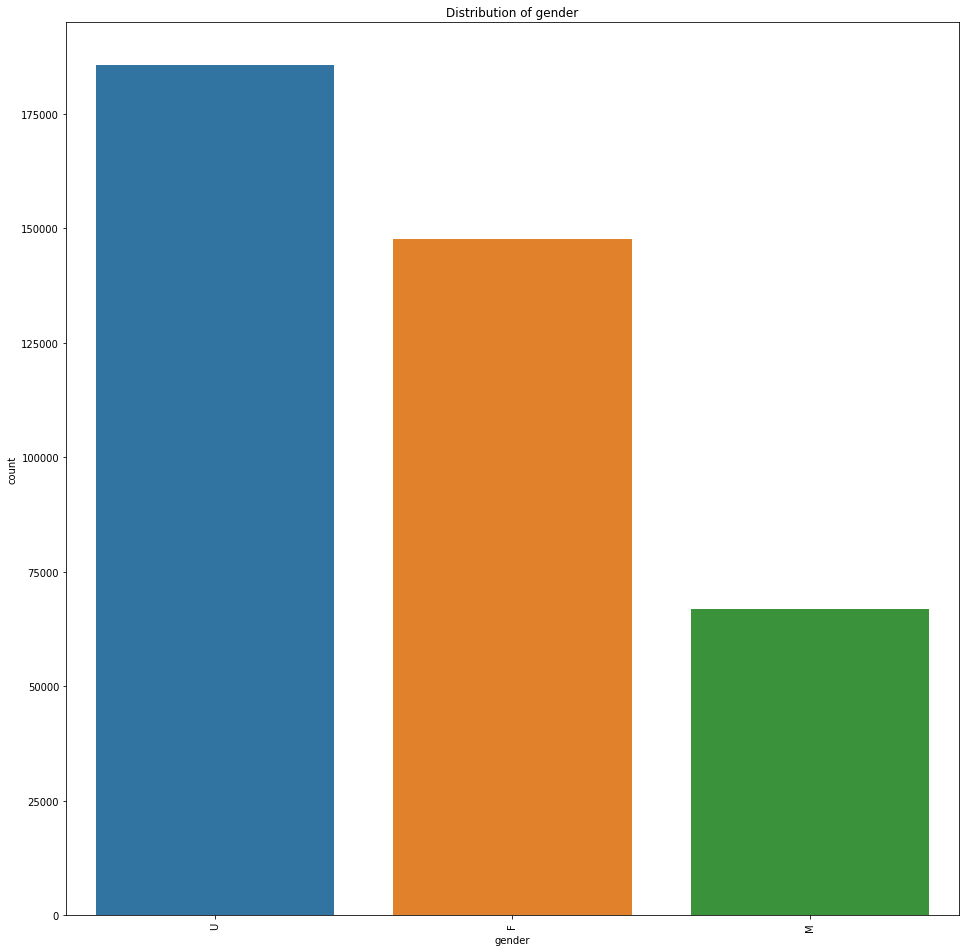

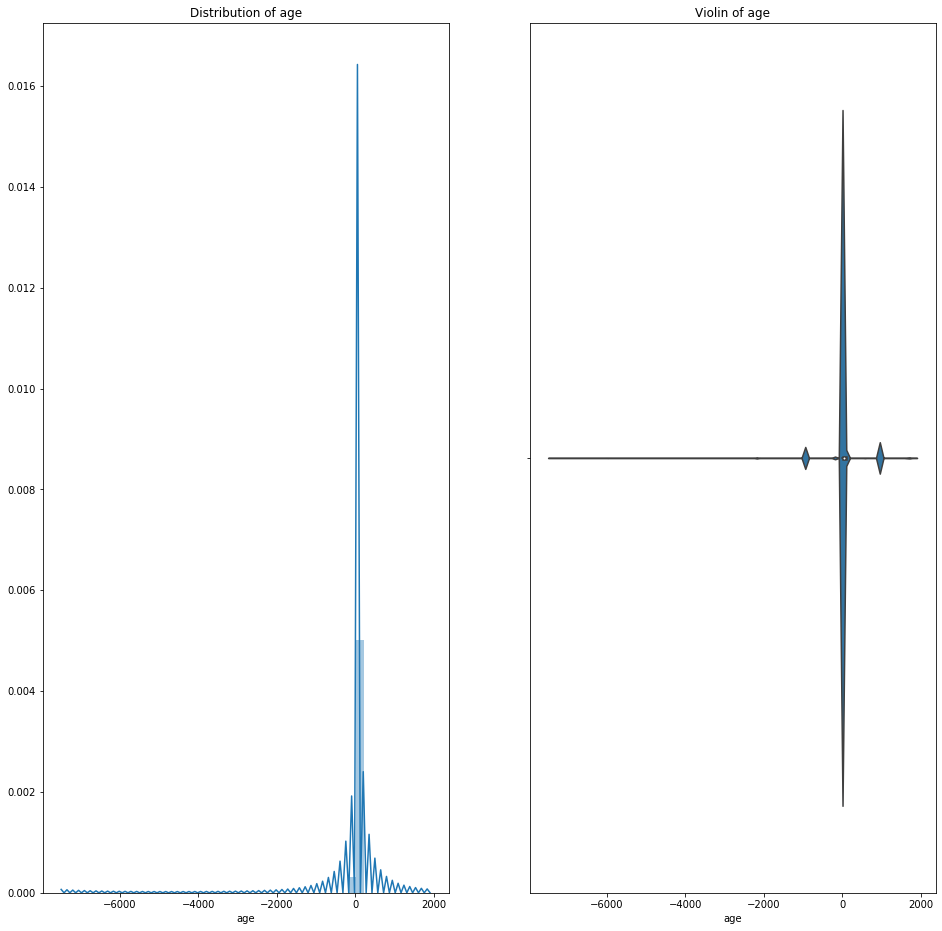

In [11]:
clients_EDA = EDA(clients)
clients_EDA.cat_plot(features=['gender'])
clients_EDA.numeric_plot()

## Work with numeric features

In [12]:
clients.df['age'].describe()

count    400162.000000
mean         46.488112
std          43.871218
min       -7491.000000
25%          34.000000
50%          45.000000
75%          59.000000
max        1901.000000
Name: age, dtype: float64

In [13]:
clients.df[clients.df['age'] <= 0].shape[0], clients.df[clients.df['age'] > 90].shape[0], clients.df.shape[0]

(138, 1139, 400162)

Age has invalid values below 0 and above 90

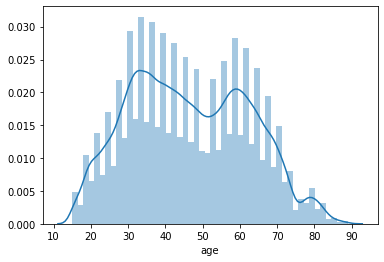

In [14]:
sns.distplot(clients.df.query('age > 14 & age < 90')['age']);

In [15]:
clients.df.loc[clients.df.query('age <= 14 | age > 90').index] = np.random.randint(14.0, 90.0)

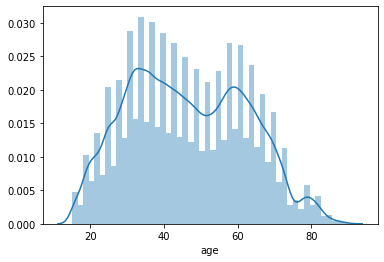

In [16]:
sns.distplot(clients.df['age']);

Distribution of age in resonable area of values didn\`t changed signifactly 

# Products lookup

## First inspection

In [17]:
products = Frame('products.csv', index_col='product_id')

print(products.cat_features, products.num_features, products.bin_features)

['level_1', 'level_2', 'level_3', 'level_4', 'brand_id', 'vendor_id'] ['segment_id', 'netto', 'is_own_trademark', 'is_alcohol'] ['is_own_trademark', 'is_alcohol']


In [18]:
products.df.head(3)

level_1     level_2     level_3     level_4  segment_id  \
product_id                                                               
0003020d3c  c3d3a8e8c6  c2a3ea8d5e  b7cda0ec0c  6376f2a852       123.0   
0003870676  e344ab2e71  52f13dac0c  d3cfe81323  6dc544533f       105.0   
0003ceaf69  c3d3a8e8c6  f2333c90fb  419bc5b424  f6148afbc0       271.0   

              brand_id   vendor_id  netto  is_own_trademark  is_alcohol  
product_id                                                               
0003020d3c  394a54a7c1  9eaff48661   0.40                 0           0  
0003870676  acd3dd483f  10486c3cf0   0.68                 0           0  
0003ceaf69  f597581079  764e660dda   0.50                 0           0

In [19]:
products.count_NaN()
print("------------------------")
products.count_unique()

There are 8 columns in dataset with missing values from 10.
Number of NaNs for each object
product_id
0003020d3c    0
0003870676    0
0003ceaf69    0
000701e093    0
0007149564    0
             ..
fffac3a287    0
fffd2946cf    0
fffd7fb409    0
fffd963a2c    0
fffd992186    0
Length: 43038, dtype: int64
------------------------
Number of NaNs for each column
level_1                3
level_2                3
level_3                3
level_4                3
segment_id          1572
brand_id            5200
vendor_id             34
netto                  3
is_own_trademark       0
is_alcohol             0
dtype: int64
------------------------
------------------------
level_1 has 4 unique values
level_2 has 43 unique values
level_3 has 202 unique values
level_4 has 791 unique values
segment_id has 117 unique values
brand_id has 4297 unique values
vendor_id has 3194 unique values
netto has 781 unique values
is_own_trademark has 2 unique values
is_alcohol has 2 unique values


e344ab2e71    22183
c3d3a8e8c6    16573
ec62ce61e3     4279
Name: level_1, dtype: int64

52f13dac0c    8891
ad2b2e17d2    6631
f2333c90fb    3310
ed2ad1797c    3257
703f4b6eb0    2396
749c619457    2393
14d373dff5    2377
c2a3ea8d5e    2209
1d2939ba1d    1717
f93982269d    1343
Name: level_2, dtype: int64

ca69ed9de2    3737
419bc5b424    2729
0f84eb7480    2571
38816369ce    2324
6b55683dad    1862
d3cfe81323    1437
0bcfc6519b    1306
a6b0dd76e0    1033
e33cc0b2a4    1001
eda7b2976b     889
Name: level_3, dtype: int64

105.0    5360
150.0    2745
271.0    1690
259.0    1523
85.0     1291
148.0    1073
1.0       912
157.0     876
263.0     873
321.0     848
Name: segment_id, dtype: int64



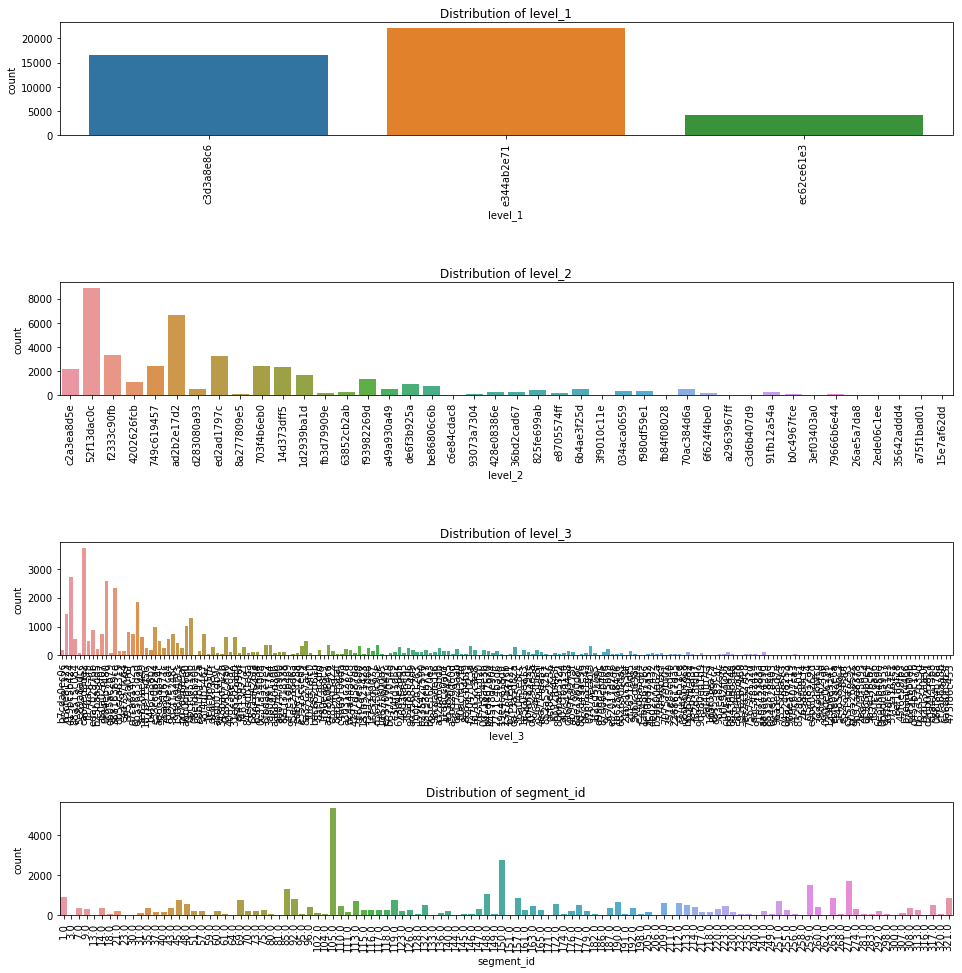

In [20]:
products_eda = EDA(products)
products_eda.cat_plot(features=['level_1', 'level_2', 'level_3', 'segment_id'])

0.50    4256
1.00    2953
0.40    2491
0.20    2410
0.30    2354
0.10    1988
0.25    1835
0.35    1330
0.45    1256
0.15    1074
Name: netto, dtype: int64



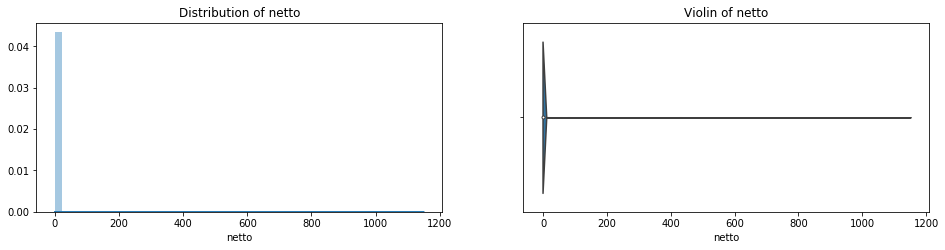

In [21]:
products_eda.numeric_plot(features=['netto'])

## Numeric feature

In [23]:
products.df[products.df['netto'] > 4].shape[0], products.df[products.df['netto'] <= 4].shape[0]

(105, 42930)

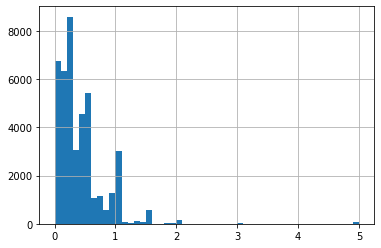

In [24]:
products.df[products.df['netto'] <= 5]['netto'].hist(bins=50);

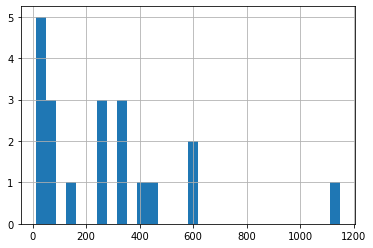

In [26]:
products.df[products.df['netto'] > 10]['netto'].hist(bins=30);

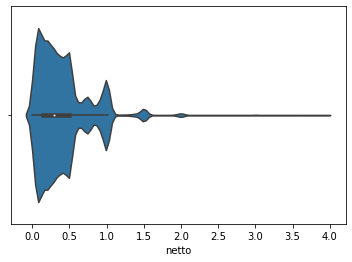

In [27]:
sns.violinplot(products.df[products.df['netto'] <= 4]['netto']);

## Level features

In [28]:
level_feat = []
for col in products.df.columns:
    if col.startswith('level'):
        level_feat.append(col)

In [29]:
bad_products = products.df[products.df['level_1'].isna()].index
bad_products

Index(['04d86b4b50', '48cc0e256d', '6a3d708544'], dtype='object', name='product_id')

In [30]:
products.df.drop(bad_products, inplace=True)

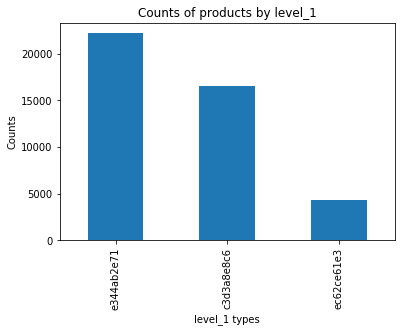

In [31]:
ax = products.df[level_feat[0]].value_counts().plot(kind='bar', title='Counts of products by level_1');
ax.set_xlabel("level_1 types");
ax.set_ylabel("Counts");

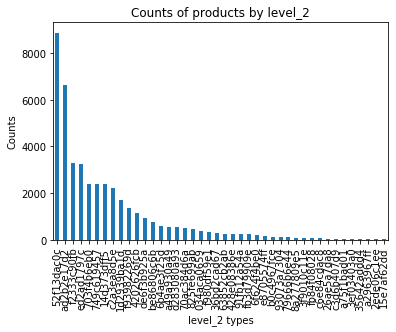

In [32]:
ax = products.df[level_feat[1]].value_counts().plot(kind='bar', title='Counts of products by level_2');
ax.set_xlabel("level_2 types");
ax.set_ylabel("Counts");

## ID Features

In [33]:
id_feat = []
for col in products.df.columns:
    if col.endswith('id'):
        id_feat.append(col)

In [34]:
for feat in id_feat:
    products.df[feat].fillna("NA_ID", inplace=True)

In [35]:
print(f"TOP10 distribution for {id_feat[0]}")
products.df[id_feat[0]].value_counts()[:10]

TOP10 distribution for segment_id


105.0    5360
150.0    2745
271.0    1690
NA_ID    1569
259.0    1523
85.0     1291
148.0    1073
1.0       912
157.0     876
263.0     873
Name: segment_id, dtype: int64

# Purchases lookup

## First inspection

In [22]:
target = pd.read_csv(os.path.join(PATH_TO_DATA, 'uplift_train.csv'), index_col='client_id')

In [23]:
new_target = target['treatment_flg'].astype('str') + target['target'].astype('str')
new_target

client_id
000012768d    01
000036f903    11
00010925a5    11
0001f552b0    11
00020e7b18    11
              ..
fffe0abb97    00
fffe0ed719    01
fffea1204c    01
fffeca6d22    10
fffff6ce77    01
Length: 200039, dtype: object

In [24]:
purchases = Frame(('purchases.csv'), parse_dates=['transaction_datetime'], index_col=0)

In [25]:
purchases.shrink()

In [26]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45786568 entries, 0 to 45786567
Data columns (total 13 columns):
client_id                  object
transaction_id             object
transaction_datetime       datetime64[ns]
regular_points_received    float32
express_points_received    float32
regular_points_spent       float32
express_points_spent       float32
purchase_sum               float32
store_id                   object
product_id                 object
product_quantity           float32
trn_sum_from_iss           float32
trn_sum_from_red           float32
dtypes: datetime64[ns](1), float32(8), object(4)
memory usage: 3.4+ GB


In [27]:
purchases.df.head(5)

client_id transaction_id transaction_datetime  regular_points_received  \
0  000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
1  000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
2  000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
3  000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
4  000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   

   express_points_received  regular_points_spent  express_points_spent  \
0                      0.0                   0.0                   0.0   
1                      0.0                   0.0                   0.0   
2                      0.0                   0.0                   0.0   
3                      0.0                   0.0                   0.0   
4                      0.0                   0.0                   0.0   

   purchase_sum    store_id  product_id  product_quantity  trn_sum_from_iss  \
0        1007.0  54a4a11a29  9a80204f78               2.0              80.0   
1        1007.0  54a4a11a29  da89ebd374               1.0              65.0   
2        1007.0  54a4a11a29  0a95e1151d               1.0              24.0   
3        1007.0  54a4a11a29  4055b15e4a               2.0              50.0   
4        1007.0  54a4a11a29  a685f1916b               1.0              22.0   

   trn_sum_from_red  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

In [28]:
purchases.df['target'] = new_target

In [29]:
purchases.df.describe(include='all')

client_id transaction_id transaction_datetime  \
count     45786568       45786568             45786568   
unique      400162        8045201              4260251   
top     7a73214c0b     f9a45c98e1  2019-02-07 15:12:53   
freq          2513            116                  150   
first          NaN            NaN  2018-11-21 21:02:33   
last           NaN            NaN  2019-03-18 23:40:03   
mean           NaN            NaN                  NaN   
std            NaN            NaN                  NaN   
min            NaN            NaN                  NaN   
25%            NaN            NaN                  NaN   
50%            NaN            NaN                  NaN   
75%            NaN            NaN                  NaN   
max            NaN            NaN                  NaN   

        regular_points_received  express_points_received  \
count              4.578657e+07             4.578657e+07   
unique                      NaN                      NaN   
top                         NaN                      NaN   
freq                        NaN                      NaN   
first                       NaN                      NaN   
last                        NaN                      NaN   
mean               6.886329e+00             6.084099e-02   
std                1.195104e+01             2.425819e+00   
min                0.000000e+00             0.000000e+00   
25%                1.400000e+00             0.000000e+00   
50%                3.800000e+00             0.000000e+00   
75%                1.030000e+01             0.000000e+00   
max                2.399000e+03             3.000000e+02   

        regular_points_spent  express_points_spent  purchase_sum    store_id  \
count           4.578657e+07          4.578657e+07  4.578657e+07    45786568   
unique                   NaN                   NaN           NaN       13882   
top                      NaN                   NaN           NaN  cfbbd53ab7   
freq                     NaN                   NaN           NaN       18984   
first                    NaN                   NaN           NaN         NaN   
last                     NaN                   NaN           NaN         NaN   
mean           -5.304835e+00         -3.181049e-01  6.389415e+02         NaN   
std             3.559064e+01          3.279348e+00  7.569911e+02         NaN   
min            -5.066000e+03         -3.000000e+02  0.000000e+00         NaN   
25%             0.000000e+00          0.000000e+00  2.860000e+02         NaN   
50%             0.000000e+00          0.000000e+00  5.390000e+02         NaN   
75%             0.000000e+00          0.000000e+00  9.760000e+02         NaN   
max             0.000000e+00          0.000000e+00  3.514904e+04         NaN   

        product_id  product_quantity  trn_sum_from_iss  trn_sum_from_red  \
count     45786568      4.578657e+07      4.578657e+07      3.043356e+06   
unique       42530               NaN               NaN               NaN   
top     4009f09b04               NaN               NaN               NaN   
freq       1824586               NaN               NaN               NaN   
first          NaN               NaN               NaN               NaN   
last           NaN               NaN               NaN               NaN   
mean           NaN      7.930188e-01      5.875556e+01      7.670548e+01   
std            NaN      3.126700e+00      8.423547e+01      8.416062e+01   
min            NaN      0.000000e+00      0.000000e+00      0.000000e+00   
25%            NaN      1.000000e+00      3.000000e+01      3.100000e+01   
50%            NaN      1.000000e+00      5.100000e+01      5.500000e+01   
75%            NaN      1.000000e+00      9.000000e+01      9.500000e+01   
max            NaN      1.494100e+04      3.514900e+04      8.789000e+03   

       target  
count       0  
unique      0  
top       NaN  
freq      NaN  
first     NaN  
last      NaN  
mean      NaN  
std       NaN  
min       NaN  
25%      

## Purchases analytics

### Count per days transactions

In [30]:
count_tr_per_day = purchases.df.groupby(purchases.df['transaction_datetime'].dt.date).count().iloc[:,0]
count_tr_per_day

transaction_datetime
2018-11-21       190
2018-11-22    338469
2018-11-23    379366
2018-11-24    356983
2018-11-25    320488
               ...  
2019-03-14    491228
2019-03-15    552207
2019-03-16    460425
2019-03-17    407371
2019-03-18    429524
Name: client_id, Length: 118, dtype: int64

In [31]:
count_tr_per_day.values, count_tr_per_day.index

(array([   190, 338469, 379366, 356983, 320488, 340280, 329950, 334298,
        347801, 386950, 373644, 330191, 350240, 328373, 337011, 340250,
        381736, 364194, 317216, 323159, 316127, 323012, 325368, 360445,
        344786, 305082, 328904, 318550, 324985, 319551, 351157, 346908,
        312213, 346092, 344078, 359948, 376945, 414105, 449503, 621704,
        428027,  99966, 224540, 253083, 292622, 316199, 345094, 301200,
        305590, 322610, 341313, 379351, 379858, 344646, 348190, 359463,
        363037, 359595, 397434, 389986, 333669, 371945, 362507, 367423,
        375954, 407414, 404897, 348498, 385727, 378272, 384635, 376829,
        416951, 409931, 353121, 385030, 410990, 426985, 422797, 486469,
        459906, 400843, 434476, 429750, 431314, 448520, 501046, 489902,
        432160, 436732, 426164, 438065, 452333, 509035, 466061, 384115,
        478923, 439117, 499767, 482871, 519936, 521912, 457953, 473653,
        465849, 475934, 587661, 520138, 457045, 443686, 499124, 

In [32]:
purchases.df['date'] = purchases.df['transaction_datetime'].dt.date

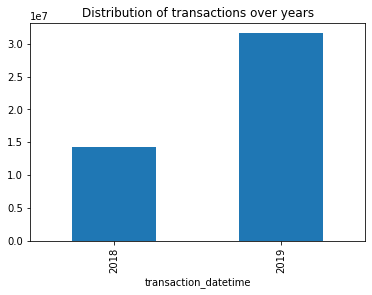

In [33]:
purchases.df['transaction_datetime'].groupby(purchases.df['transaction_datetime'].dt.year).count().plot(kind='bar');
plt.title("Distribution of transactions over years");

In [34]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(y=count_tr_per_day.values,
                 x=count_tr_per_day.index)])
fig.update_layout(
    title="Distribution of puchases over days",
    xaxis_title="Days",
    yaxis_title="Number of transactions",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

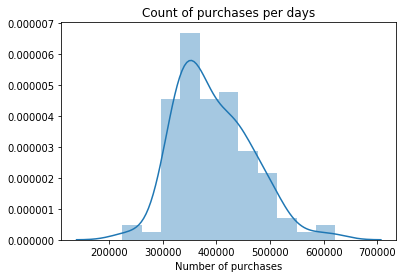

In [35]:
sns.distplot(count_tr_per_day[count_tr_per_day > 10e4]);
plt.xlabel("Number of purchases")
plt.title("Count of purchases per days");

In [36]:
count_tr_per_day.describe()

count       118.000000
mean     388021.762712
std       82111.531981
min         190.000000
25%      340538.250000
50%      379358.500000
75%      436168.000000
max      621704.000000
Name: client_id, dtype: float64

In [37]:
holidays = [pd.to_datetime(i).date() for i in ['2019-01-01', '2019-02-23', '2019-03-08']]
strange_days = [pd.to_datetime(i).date() for i in ['2018-12-30', '2019-03-07', '2019-01-01', '2018-11-21']]

In [65]:
# check for deviation more than 3 std
# 388021.762712 + (3 * 82111.531981) < count_tr_per_day[count_tr_per_day.index == pd.to_datetime('2018-12-30')]

transaction_datetime
2018-12-30    False
Name: client_id, dtype: bool

### Count loyal clients

In [39]:
old_clients = set(purchases.df[purchases.df['transaction_datetime'].dt.year == 2018]['client_id'].values)
len(old_clients), clients.df.shape[0]

(338156, 400162)

In [40]:
proved_clients = old_clients.intersection(set(purchases.df[purchases.df['transaction_datetime'].dt.year == 2019]['client_id'].values))
len(proved_clients)

338156

all clients that have transactions in 2018 are still loyal at 2019

In [41]:
# clients without purchases for last 2 month
sum(purchases.df.groupby('client_id')['transaction_datetime'].max() < '2019-01-18')

0

all clients are regular customers

In [42]:
sleeping_clients = clients.df[purchases.df.groupby('client_id')['transaction_datetime']\
                              .max() < '2019-02-26'].index.to_list()
len(sleeping_clients)

4994

## First conclusions

<ul>
    <li>All clients are loyal and there is no need to clean them. In case of emergency we could cluster them for sleeping/active</li>
    <li>Distribution of transactions over time(days) is similar. But looks suspiciously that on 14 February there was so many transactions, but no of top 15 products was alcohol. And, by the way, that was Thursday. Things to explore -> distribution over weekends and cluster customers that by products that time. Cluster time of day in transactions.</li>
    <li>We have outlier in day 2018-12-30. Let`s take a look what will be, if we drop transactions by this day</li>
</ul>

# Aggregative features

In [67]:
holyday_customers = list(set(clients.df.index).difference(set(purchases.df[~purchases.df['date'].isin(strange_days)]['client_id'].unique())))
len(holyday_customers)

135

In [215]:
purch_full = pd.merge(purchases.df, products.df, how='inner', on='product_id')
purch_full['date'] = purch_full['transaction_datetime'].dt.date
purch_full['segment_id'].loc[purch_full['segment_id'] == 'NA_ID'] = -1
purch_full['segment_id'] = purch_full['segment_id'].astype('int')

In [216]:
purch_full['is_own_trademark'] = pd.to_numeric(purch_full['is_own_trademark'],
                                               downcast='integer',
                                               errors='ignore')
purch_full['is_alcohol'] = pd.to_numeric(purch_full['is_alcohol'],
                                               downcast='integer',
                                               errors='ignore')
purch_full['netto'] = pd.to_numeric(purch_full['netto'],
                                               downcast='float',
                                               errors='ignore')
purch_full['segment_id'] = pd.to_numeric(purch_full['segment_id'],
                                               downcast='integer',
                                               errors='ignore')

In [217]:
purch_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44470603 entries, 0 to 44470602
Data columns (total 27 columns):
client_id                  object
transaction_id             object
transaction_datetime       datetime64[ns]
regular_points_received    float32
express_points_received    float32
regular_points_spent       float32
express_points_spent       float32
purchase_sum               float32
store_id                   object
product_id                 object
product_quantity           float32
trn_sum_from_iss           float32
trn_sum_from_red           float32
date                       object
is_holiday                 int8
is_before_holiday          int8
target                     object
level_1                    object
level_2                    object
level_3                    object
level_4                    object
segment_id                 int16
brand_id                   object
vendor_id                  object
netto                      float32
is_own_trademark       

In [111]:
group_by_dt = purchases.df.set_index('transaction_datetime').groupby(['client_id','transaction_id'])

In [112]:
group_by_dt.last()

regular_points_received  express_points_received  \
client_id  transaction_id                                                     
000012768d 6a0e96d0bc                     8.000000                      0.0   
           7e3e2e3984                    10.000000                      0.0   
           b34f23306e                     2.000000                      0.0   
           c1ca85d462                     5.700000                      0.0   
000036f903 0a3d640bf4                     7.000000                      0.0   
...                                            ...                      ...   
fffff6ce77 e9182e5887                     0.700000                      0.0   
           eba2694c0c                     1.800000                      0.0   
           f0af5bcc0b                     0.900000                      0.0   
           f58417b669                    20.700001                      0.0   
           f8dd10c7f3                     8.200000                      0.0   

                           regular_points_spent  express_points_spent  \
client_id  transaction_id                                               
000012768d 6a0e96d0bc                       0.0                   0.0   
           7e3e2e3984                       0.0                   0.0   
           b34f23306e                       0.0                   0.0   
           c1ca85d462                       0.0                   0.0   
000036f903 0a3d640bf4                       0.0                   0.0   
...                                         ...                   ...   
fffff6ce77 e9182e5887                       0.0                   0.0   
           eba2694c0c                       0.0                   0.0   
           f0af5bcc0b                       0.0                   0.0   
           f58417b669                       0.0                   0.0   
           f8dd10c7f3                       0.0                   0.0   

                           purchase_sum    store_id  product_id  \
client_id  transaction_id                                         
000012768d 6a0e96d0bc             803.0  017c89b915  60d701d7db   
           7e3e2e3984            1007.0  54a4a11a29  6bbace0869   
           b34f23306e             419.0  017c89b915  15ccaa8685   
           c1ca85d462             574.0  ed8d2683fd  1acd9131f6   
000036f903 0a3d640bf4             700.0  3c6c3b17f2  ac81544ebc   
...                                 ...         ...         ...   
fffff6ce77 e9182e5887             157.0  5ec64bdccb  3ff5173ff9   
           eba2694c0c             446.0  5ec64bdccb  451cf50365   
           f0af5bcc0b             183.0  5ec64bdccb  0fed01b157   
           f58417b669            2077.0  6e4faad02e  d1d9198823   
           f8dd10c7f3             826.0  6e4faad02e  8d1dd1e72e   

                           product_quantity  trn_sum_from_iss  \
client_id  transaction_id                                       
000012768d 6a0e96d0bc                   1.0              57.0   
           7e3e2e3984                   1.0              82.0   
           b34f23306e                   1.0              41.0   
           c1ca85d462                   1.0              50.0   
000036f903 0a3d640bf4                   1.0              20.0   
...                                     ...               ...   
fffff6ce77 e9182e5887                   6.0             108.0   
           eba2694c0c                   1.0              38.0   
           f0af5bcc0b                   1.0              36.0   
           f58417b669                   2.0             126.0   
           f8dd10c7f3                   1.0             190.0   

                           trn_sum_from_red        date  is_holiday  \
client_id  transaction_id                                             
000012768d 6a0e96d0bc                   NaN  2019-03-08           1   
           7e3e2e3984                   NaN  2018-12-01           0   
           b34f23306e                   NaN  20

In [ ]:
# purchases.df.set_index('transaction_datetime').groupby('client_id').apply(pd.DataFrame.last, offset='1M')

In [92]:
inspected_columns = ['regular_points_received', 'express_points_received',
                     'regular_points_spent', 'express_points_spent', 
                     'store_id', 'product_quantity', 'purchase_sum']

In [93]:
all_time = purchases.df.groupby(['client_id', 'transaction_id'])[inspected_columns].last()
last_month = purchases.df[purchases.df['transaction_datetime'] > '2019-02-18'].groupby\
                (['client_id', 'transaction_id'])[inspected_columns].last()
last_month.head(8)

regular_points_received  express_points_received  \
client_id  transaction_id                                                     
000012768d 6a0e96d0bc                          8.0                      0.0   
           b34f23306e                          2.0                      0.0   
000036f903 2e83f51925                          2.1                      0.0   
           46785fbddc                          1.3                      0.0   
           7bc561c52e                          2.4                      0.0   
           8203af0a90                          2.5                      0.0   
           9884d05413                          1.2                      0.0   
           b898a018b5                          0.4                      0.0   

                           regular_points_spent  express_points_spent  \
client_id  transaction_id                                               
000012768d 6a0e96d0bc                       0.0                   0.0   
           b34f23306e                       0.0                   0.0   
000036f903 2e83f51925                       0.0                   0.0   
           46785fbddc                       0.0                   0.0   
           7bc561c52e                       0.0                   0.0   
           8203af0a90                       0.0                   0.0   
           9884d05413                       0.0                   0.0   
           b898a018b5                       0.0                   0.0   

                             store_id  product_quantity  purchase_sum  
client_id  transaction_id                                              
000012768d 6a0e96d0bc      017c89b915               1.0         803.0  
           b34f23306e      017c89b915               1.0         419.0  
000036f903 2e83f51925      465a702399               1.0         431.0  
           46785fbddc      3c6c3b17f2               1.0         268.0  
           7bc561c52e      6381a55c22               1.0         460.0  
           8203af0a90      6381a55c22               1.0         506.0  
           9884d05413      6381a55c22               0.0         243.0  
           b898a018b5      6381a55c22               1.0          93.0

In [94]:
all_time.head(8)

regular_points_received  express_points_received  \
client_id  transaction_id                                                     
000012768d 6a0e96d0bc                          8.0                      0.0   
           7e3e2e3984                         10.0                      0.0   
           b34f23306e                          2.0                      0.0   
           c1ca85d462                          5.7                      0.0   
000036f903 0a3d640bf4                          7.0                      0.0   
           12b218b054                          1.2                      0.0   
           13588372c5                          0.6                      0.0   
           1af98450b3                          0.7                      0.0   

                           regular_points_spent  express_points_spent  \
client_id  transaction_id                                               
000012768d 6a0e96d0bc                       0.0                   0.0   
           7e3e2e3984                       0.0                   0.0   
           b34f23306e                       0.0                   0.0   
           c1ca85d462                       0.0                   0.0   
000036f903 0a3d640bf4                       0.0                   0.0   
           12b218b054                       0.0                   0.0   
           13588372c5                       0.0                   0.0   
           1af98450b3                       0.0                   0.0   

                             store_id  product_quantity  purchase_sum  
client_id  transaction_id                                              
000012768d 6a0e96d0bc      017c89b915               1.0         803.0  
           7e3e2e3984      54a4a11a29               1.0        1007.0  
           b34f23306e      017c89b915               1.0         419.0  
           c1ca85d462      ed8d2683fd               1.0         574.0  
000036f903 0a3d640bf4      3c6c3b17f2               1.0         700.0  
           12b218b054      6381a55c22               1.0         241.0  
           13588372c5      6381a55c22               1.0         124.0  
           1af98450b3      6381a55c22               1.0         157.0

## Explore aggregative features

In [95]:
purchases.df[purchases.df['client_id'].isin(holyday_customers)].describe(include='all')

client_id transaction_id transaction_datetime  \
count         1119           1119                 1119   
unique         135            165                  165   
top     bfc08d03cb     e59a9b075f  2019-03-07 15:56:23   
freq            41             41                   41   
first          NaN            NaN  2018-12-30 06:45:11   
last           NaN            NaN  2019-03-07 21:22:58   
mean           NaN            NaN                  NaN   
std            NaN            NaN                  NaN   
min            NaN            NaN                  NaN   
25%            NaN            NaN                  NaN   
50%            NaN            NaN                  NaN   
75%            NaN            NaN                  NaN   
max            NaN            NaN                  NaN   

        regular_points_received  express_points_received  \
count               1119.000000                   1119.0   
unique                      NaN                      NaN   
top                         NaN                      NaN   
freq                        NaN                      NaN   
first                       NaN                      NaN   
last                        NaN                      NaN   
mean                  12.482619                      0.0   
std                   10.658722                      0.0   
min                    0.000000                      0.0   
25%                    2.600000                      0.0   
50%                   10.100000                      0.0   
75%                   17.700001                      0.0   
max                   40.500000                      0.0   

        regular_points_spent  express_points_spent  purchase_sum    store_id  \
count            1119.000000           1119.000000   1119.000000        1119   
unique                   NaN                   NaN           NaN         143   
top                      NaN                   NaN           NaN  32dc1a1ba8   
freq                     NaN                   NaN           NaN          41   
first                    NaN                   NaN           NaN         NaN   
last                     NaN                   NaN           NaN         NaN   
mean              -14.599643             -1.546023   1259.524658         NaN   
std                62.582378              8.627955    947.786987         NaN   
min              -669.000000            -50.000000      5.000000         NaN   
25%                 0.000000              0.000000    527.000000         NaN   
50%                 0.000000              0.000000    911.830017         NaN   
75%                 0.000000              0.000000   1728.229980         NaN   
max                 0.000000              0.000000   3729.870117         NaN   

        product_id  product_quantity  trn_sum_from_iss  trn_sum_from_red  \
count         1119       1119.000000       1119.000000        150.000000   
unique         821               NaN               NaN               NaN   
top     4009f09b04               NaN               NaN               NaN   
freq            55               NaN               NaN               NaN   
first          NaN               NaN               NaN               NaN   
last           NaN               NaN               NaN               NaN   
mean           NaN          1.393208         94.790886        100.766670   
std            NaN          1.473370        114.527130        121.690727   
min            NaN          0.000000          0.000000          0.000000   
25%            NaN          1.000000         34.000000         33.250000   
50%            NaN          1.000000         65.000000         65.000000   
75%            NaN          1.000000        115.000000        132.250000   
max            NaN         20.000000       1980.000000        900.000000   

       target        date  
count       0        1119  
unique      0           3  
top       NaN  2019-03-07  
freq      NaN         990  
first     NaN         NaN  
l

In [96]:
purchases.df[purchases.df['client_id'].isin(holyday_customers)]['transaction_datetime'].unique()

array(['2019-03-07T13:39:22.000000000', '2019-03-07T13:09:54.000000000',
       '2019-03-07T11:50:26.000000000', '2019-03-07T14:58:34.000000000',
       '2019-03-07T17:01:40.000000000', '2019-03-07T12:21:52.000000000',
       '2019-03-07T16:36:01.000000000', '2019-03-07T08:55:39.000000000',
       '2019-03-07T21:22:58.000000000', '2019-03-07T08:04:18.000000000',
       '2019-03-07T10:58:47.000000000', '2019-03-07T15:45:22.000000000',
       '2019-03-07T15:46:00.000000000', '2018-12-30T12:15:02.000000000',
       '2019-03-07T12:13:36.000000000', '2019-03-07T17:56:59.000000000',
       '2019-03-07T11:42:28.000000000', '2019-03-07T07:39:54.000000000',
       '2019-03-07T07:29:59.000000000', '2019-03-07T14:12:09.000000000',
       '2019-03-07T13:31:34.000000000', '2019-03-07T11:37:54.000000000',
       '2019-03-07T11:29:19.000000000', '2019-03-07T13:54:43.000000000',
       '2019-03-07T15:23:39.000000000', '2019-03-07T10:38:36.000000000',
       '2018-12-30T10:57:12.000000000', '2019-03-07

All this clients made their purchasing only on 2 days -> 2018-12-30 or 2019-03-07
We will mark all this clients as not loyal, and there is no need to send them messages

In [97]:
sns.set(style="whitegrid")

def plot_two_graphs(data1, data2, feat):
    _, _ = plt.subplots(figsize=(16, 16))
    plt.subplot(2, 1,1)
    sns.violinplot(x=feat, data=data1, y='target', palette="Set2")
    plt.title(f'Distribution of {feat} for the whole period');
    plt.subplot(2, 1,2)
    sns.violinplot(x=feat, data=data2, y='target', palette="Set2")
    plt.title(f'Distribution of {feat} for last month');

In [98]:
def plot_two_cat_graphs(data1, data2, feat_x, feat_y):
    _, _ = plt.subplots(figsize=(16, 16))
    plt.subplot(2, 1,1)
    sns.catplot(x=feat_x, data=data1, y=feat_y, hue='target', palette="Set2")
    plt.title(f'Distribution of {feat} for the whole period');
    plt.subplot(2, 1,2)
    sns.catplot(x=feat_x, data=data2, y=feat_y, hue='target', palette="Set2")
    plt.title(f'Distribution of {feat} for last month');

In [99]:
data1 = all_time.groupby('client_id').sum()
data2 = last_month.groupby('client_id').sum()
data1['target'] = data2['target'] = new_target
data1['target'].fillna('test', inplace=True)
data2['target'].fillna('test', inplace=True)

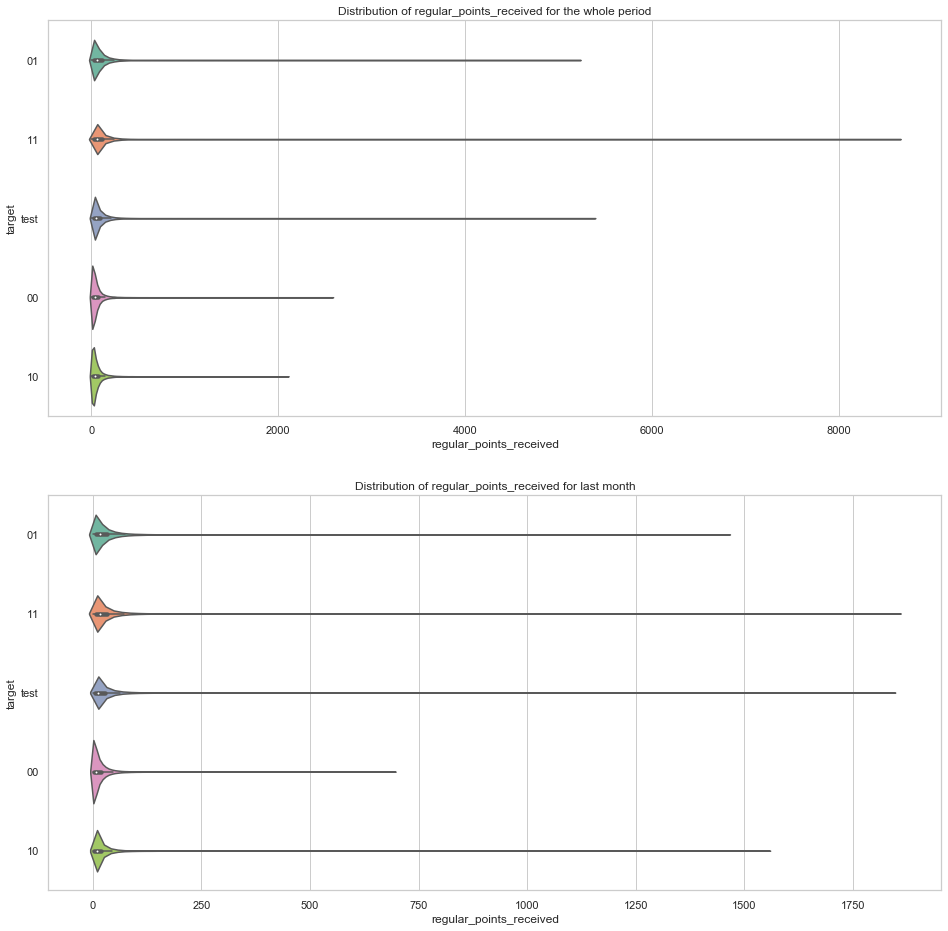

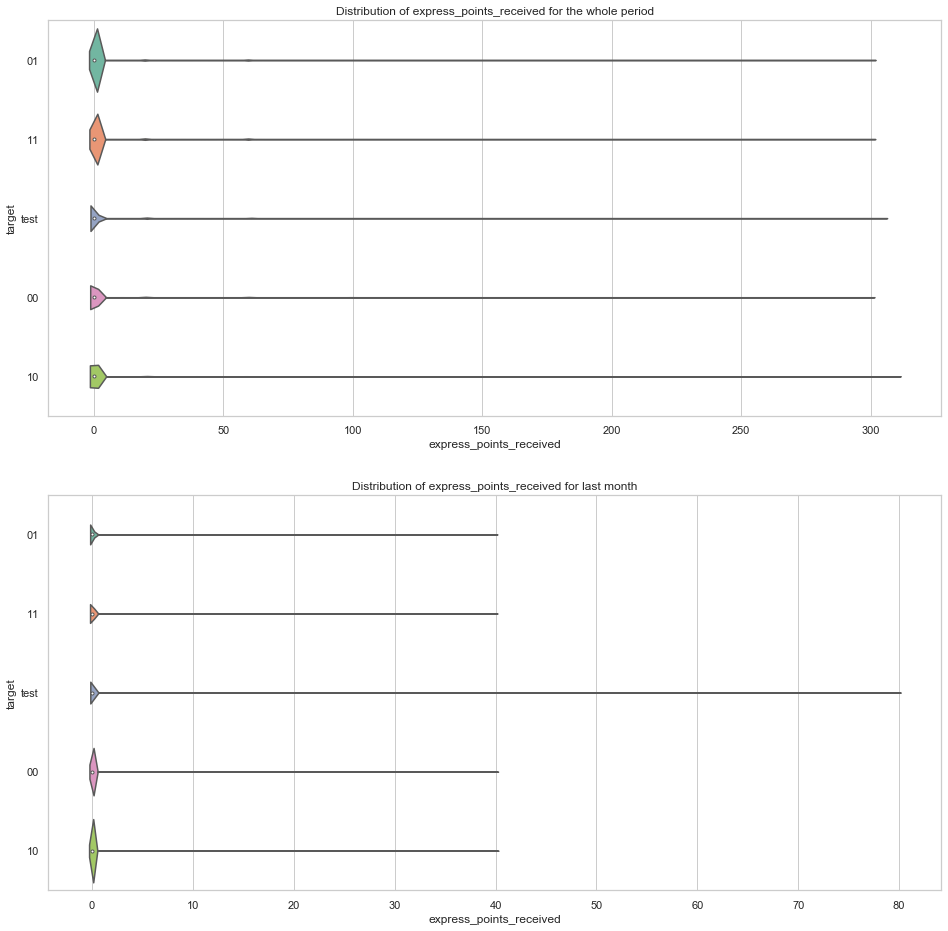

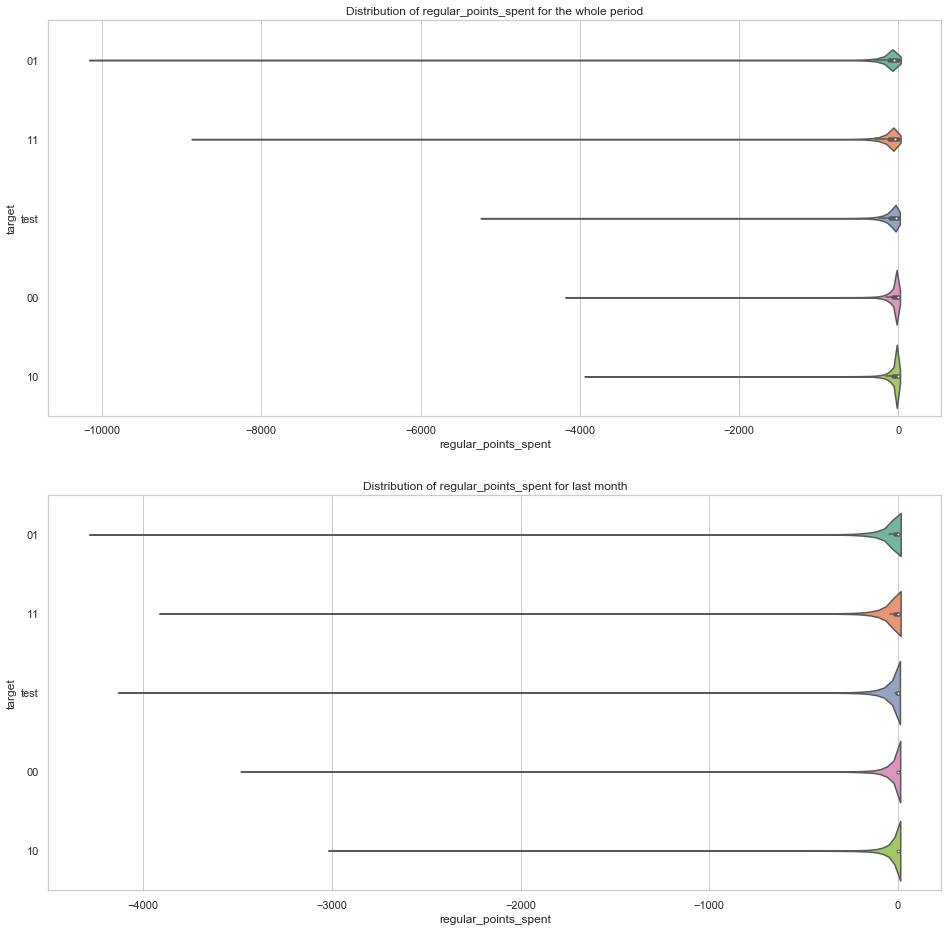

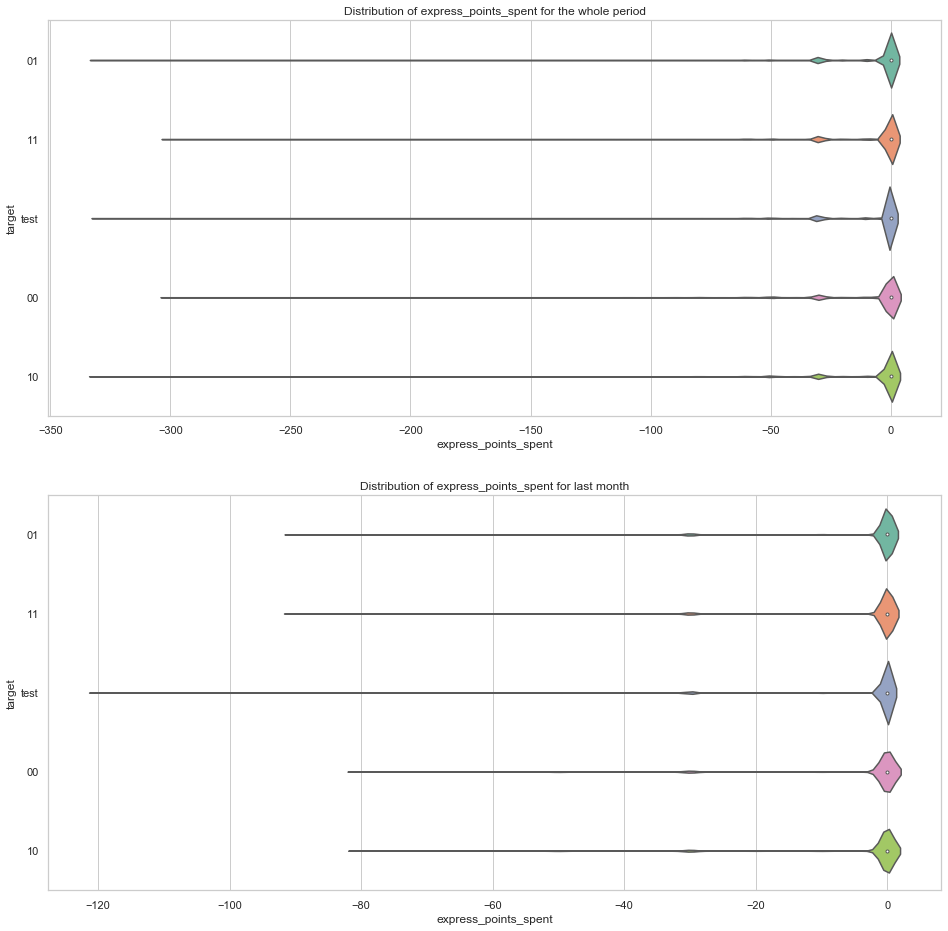

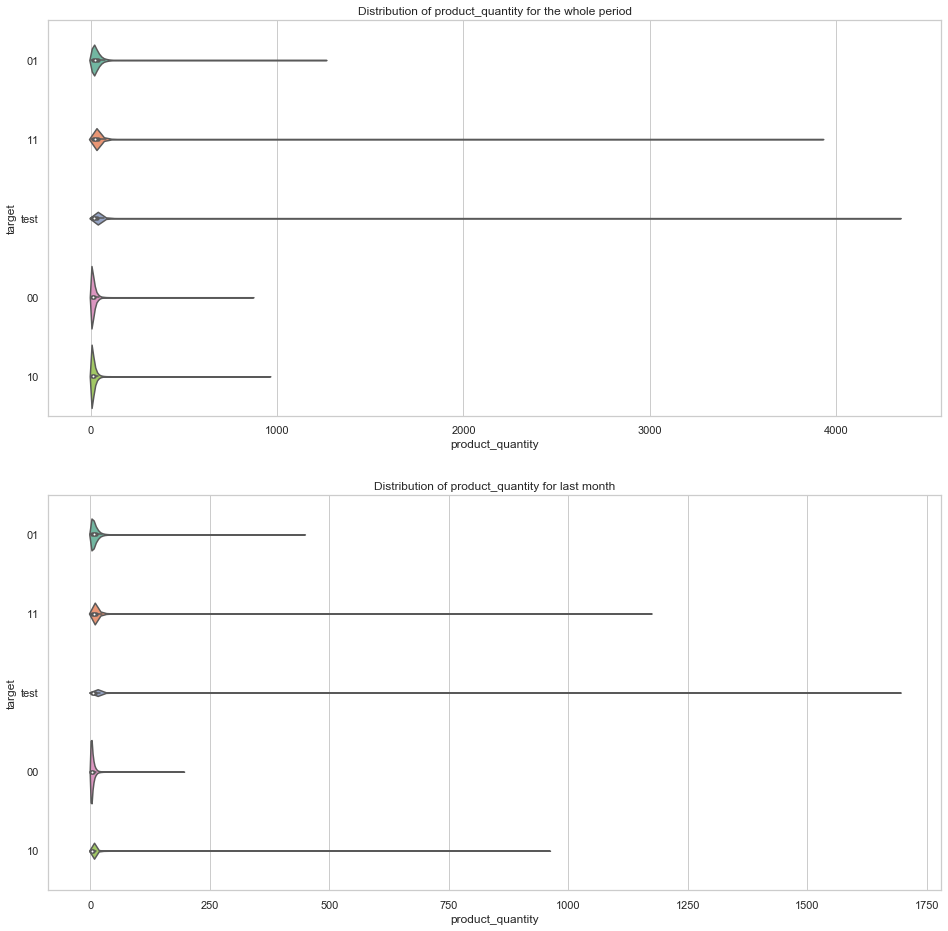

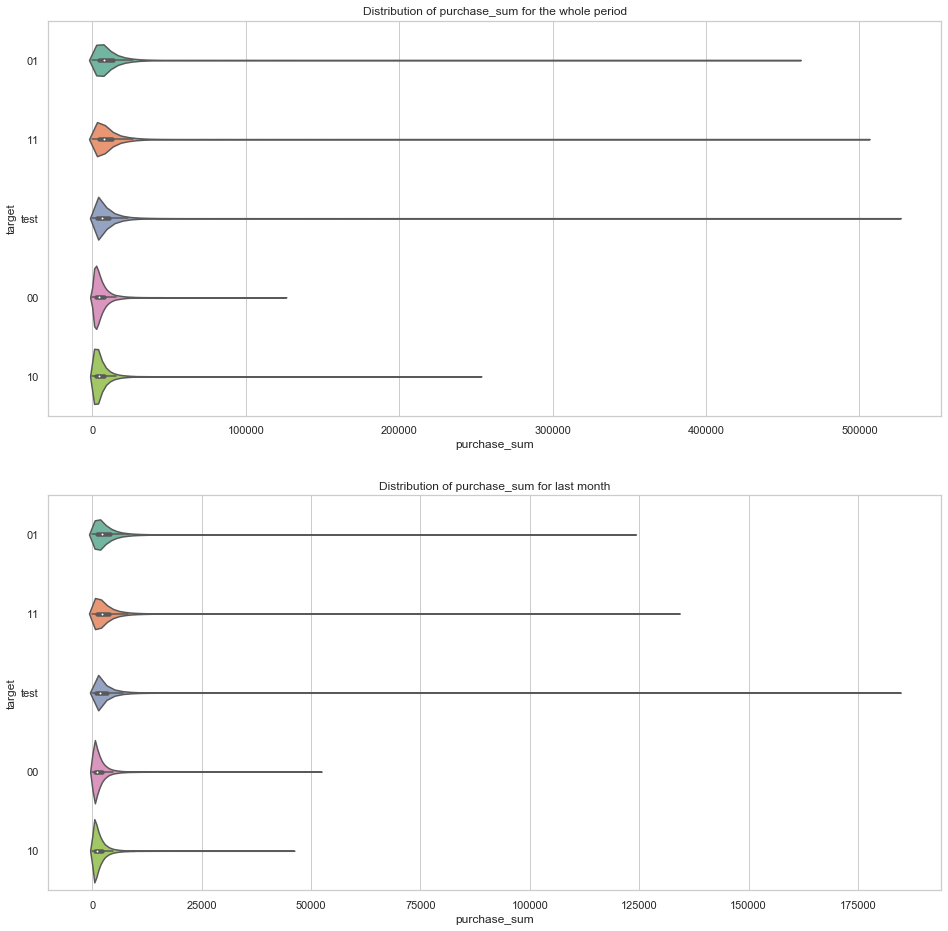

In [100]:
for feat in ['regular_points_received', 'express_points_received',
                                 'regular_points_spent', 'express_points_spent', 
                                 'product_quantity', 'purchase_sum']:
    plot_two_graphs(data1, data2, feat)

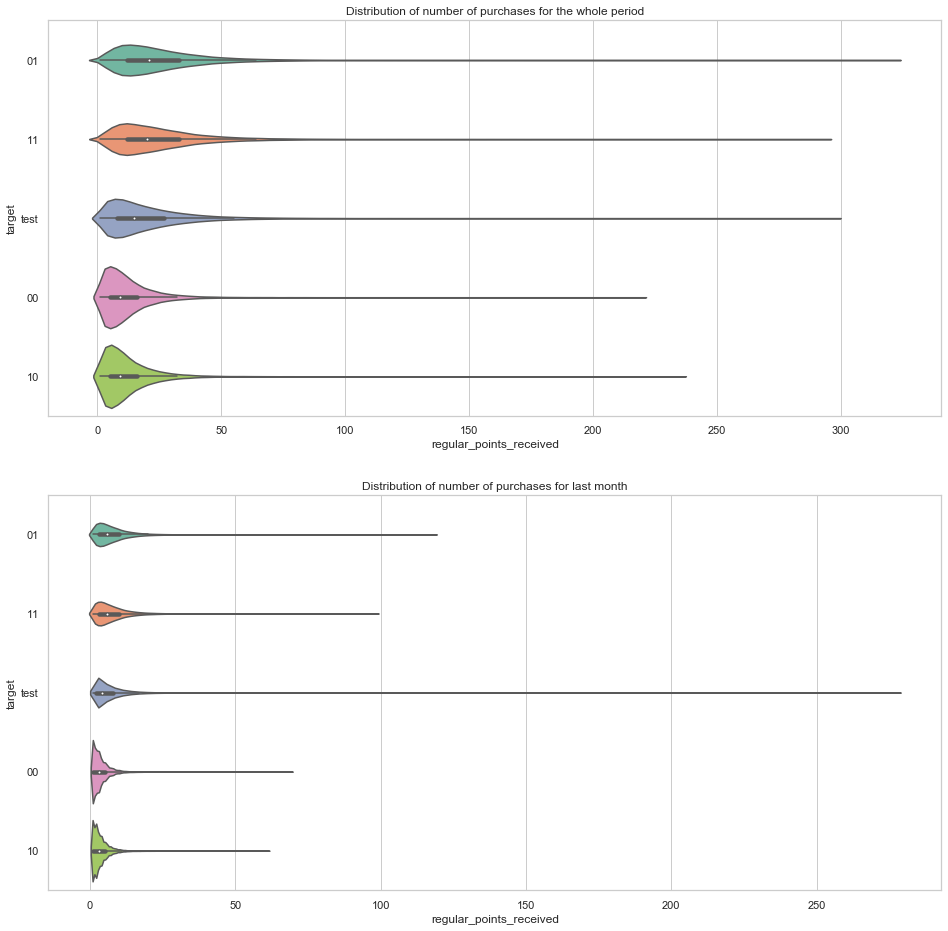

In [101]:
data1 = pd.DataFrame(all_time.groupby('client_id').count().iloc[:,0])
data2 = pd.DataFrame(last_month.groupby('client_id').count().iloc[:,0])
data1['target'] = data2['target'] = new_target
data1['target'].fillna('test', inplace=True)
data2['target'].fillna('test', inplace=True)

_, _ = plt.subplots(figsize=(16, 16))
plt.subplot(2, 1,1)
sns.violinplot(x='regular_points_received', data=data1, y='target', palette="Set2")
plt.title(f'Distribution of number of purchases for the whole period');
plt.subplot(2, 1,2)
sns.violinplot(x='regular_points_received', data=data2, y='target', palette="Set2")
plt.title(f'Distribution of number of purchases for last month');

## Simple features

### Sum aggregates

In [102]:
total_sum = all_time.groupby('client_id').sum()
total_sum_last = last_month.groupby('client_id').sum()
total_sum.head(3)

regular_points_received  express_points_received  \
client_id                                                      
000012768d                25.700001                      0.0   
000036f903                54.900002                     60.0   
000048b7a6                26.500000                      0.0   

            regular_points_spent  express_points_spent  product_quantity  \
client_id                                                                  
000012768d                   0.0                   0.0               4.0   
000036f903                   0.0                   0.0              32.0   
000048b7a6                   0.0                   0.0              11.0   

            purchase_sum  
client_id                 
000012768d        2803.0  
000036f903        9805.0  
000048b7a6        3772.0

In [103]:
total_count = all_time.groupby('client_id')['purchase_sum'].count()
total_count_last = last_month.groupby('client_id')['purchase_sum'].count()
print(total_count.head(3))
print(total_count_last.head(3))

client_id
000012768d     4
000036f903    32
000048b7a6     8
Name: purchase_sum, dtype: int64
client_id
000012768d    2
000036f903    8
000048b7a6    1
Name: purchase_sum, dtype: int64


In [104]:
nunique_stores = all_time.groupby('client_id')['store_id'].nunique()
nunique_stores_last = last_month.groupby('client_id')['store_id'].nunique()
nunique_stores.head(3)

client_id
000012768d    3
000036f903    5
000048b7a6    2
Name: store_id, dtype: int64

In [105]:
nunique_stores_last.head(3)

client_id
000012768d    1
000036f903    4
000048b7a6    1
Name: store_id, dtype: int64

In [110]:
inspected_columns.remove('store_id')

In [111]:
aggr = pd.concat([total_count, total_count_last, total_sum, total_sum_last,
                  nunique_stores, nunique_stores_last],axis=1).set_index(clients.df.index)

aggr.columns = ['trans_count_all','trans_count_last_month']\
                   + list(c+"_sum_all" for c in inspected_columns)\
                   + list(c+"_sum_last_month" for c in inspected_columns)\
                   + ['stores_visited_all', 'stores_visited_last_month']
aggr

trans_count_all  trans_count_last_month  \
client_id                                             
000012768d                4                       2   
000036f903               32                       8   
000048b7a6                8                       1   
000073194a               17                       6   
00007c7133               11                       1   
...                     ...                     ...   
fffece623e               24                       5   
ffff3dfff8               17                       5   
ffffaab9da                7                       2   
ffffeb5619                7                       6   
fffff6ce77               32                      10   

            regular_points_received_sum_all  express_points_received_sum_all  \
client_id                                                                      
000012768d                        25.700001                              0.0   
000036f903                        54.900002                             60.0   
000048b7a6                        26.500000                              0.0   
000073194a                        74.900002                              0.0   
00007c7133                        56.599998                              0.0   
...                                     ...                              ...   
fffece623e                        38.400002                              0.0   
ffff3dfff8                       117.900002                              0.0   
ffffaab9da                        34.000000                              0.0   
ffffeb5619                       117.500000                              0.0   
fffff6ce77                       221.300003                              0.0   

            regular_points_spent_sum_all  express_points_spent_sum_all  \
client_id                                                                
000012768d                           0.0                           0.0   
000036f903                           0.0                           0.0   
000048b7a6                           0.0                           0.0   
000073194a                         -96.0                           0.0   
00007c7133                        -240.0                           0.0   
...                                  ...                           ...   
fffece623e                         -68.0                           0.0   
ffff3dfff8                        -182.0                           0.0   
ffffaab9da                          -6.0                           0.0   
ffffeb5619                           0.0                           0.0   
fffff6ce77                        -302.0                           0.0   

            product_quantity_sum_all  purchase_sum_sum_all  \
client_id                                                    
000012768d                       4.0           2803.000000   
000036f903                      32.0           9805.000000   
000048b7a6                      11.0           3772.000000   
000073194a                      27.0           9601.400391   
00007c7133                      12.0           6719.839844   
...                              ...                   ...   
fffece623e                      24.0           6530.010254   
ffff3dfff8                      23.0           7264.839844   
ffffaab9da                      17.0           3791.000000   
ffffeb5619                       8.0          15226.219727   
fffff6ce77                      43.0          18560.589844   

            regular_points_received_sum_last_month  \
client_id                                            
000012768d                               10.000000   
000036f903                               13.700000   
000048b7a6                                1.200000   
000073194a                               25.000000   
00007c7133                                1.900000   
...                                            ...   
fffece623e                                4.300000   

In [112]:
aggr['target'] = new_target
aggr['target'].fillna('test', inplace=True)

In [113]:
def violin_for_aggr(feature):
    _, _ = plt.subplots(figsize=(10, 10))
    sns.violinplot(x=feature, data=aggr, y='target', palette="Set3")
    plt.title(f'Distribution of {feature}');
    print(aggr[feature].describe())

### Mean aggregative

In [114]:
total_mean = all_time.groupby('client_id').mean()
total_mean_last = last_month.groupby('client_id').mean()
total_mean.columns = list(c+"_mean_all" for c in inspected_columns)
total_mean_last.columns = list(c+"_mean_last_month" for c in inspected_columns)
total_mean_last.sample()

regular_points_received_mean_last_month  \
client_id                                             
857aa2d0ae                                 6.816667   

            express_points_received_mean_last_month  \
client_id                                             
857aa2d0ae                                      0.0   

            regular_points_spent_mean_last_month  \
client_id                                          
857aa2d0ae                                   0.0   

            express_points_spent_mean_last_month  \
client_id                                          
857aa2d0ae                                   0.0   

            product_quantity_mean_last_month  purchase_sum_mean_last_month  
client_id                                                                   
857aa2d0ae                               1.5                    738.563354

In [115]:
aggr = pd.concat([aggr, total_mean, total_mean_last], axis=1).set_index(clients.df.index)
aggr.head(3)

trans_count_all  trans_count_last_month  \
client_id                                             
000012768d                4                       2   
000036f903               32                       8   
000048b7a6                8                       1   

            regular_points_received_sum_all  express_points_received_sum_all  \
client_id                                                                      
000012768d                        25.700001                              0.0   
000036f903                        54.900002                             60.0   
000048b7a6                        26.500000                              0.0   

            regular_points_spent_sum_all  express_points_spent_sum_all  \
client_id                                                                
000012768d                           0.0                           0.0   
000036f903                           0.0                           0.0   
000048b7a6                           0.0                           0.0   

            product_quantity_sum_all  purchase_sum_sum_all  \
client_id                                                    
000012768d                       4.0                2803.0   
000036f903                      32.0                9805.0   
000048b7a6                      11.0                3772.0   

            regular_points_received_sum_last_month  \
client_id                                            
000012768d                                    10.0   
000036f903                                    13.7   
000048b7a6                                     1.2   

            express_points_received_sum_last_month  \
client_id                                            
000012768d                                     0.0   
000036f903                                     0.0   
000048b7a6                                     0.0   

            regular_points_spent_sum_last_month  \
client_id                                         
000012768d                                  0.0   
000036f903                                  0.0   
000048b7a6                                  0.0   

            express_points_spent_sum_last_month  \
client_id                                         
000012768d                                  0.0   
000036f903                                  0.0   
000048b7a6                                  0.0   

            product_quantity_sum_last_month  purchase_sum_sum_last_month  \
client_id                                                                  
000012768d                              2.0                       1222.0   
000036f903                              8.0                       2784.0   
000048b7a6                              2.0                        342.0   

            stores_visited_all  stores_visited_last_month target  \
client_id                                                          
000012768d                   3                          1     01   
000036f903                   5                          4     11   
000048b7a6                   2                          1   test   

            regular_points_received_mean_all  \
client_id                                      
000012768d                          6.425000   
000036f903                          1.715625   
000048b7a6                          3.312500   

            express_points_received_mean_all  regular_points_spent_mean_all  \
client_id                                                                     
000012768d                             0.000                            0.0   
000036f903                             1.875                            0.0   
000048b7a6                             0.000                            0.0   

            express_points_spent_mean_all  product_quantity_mean_all  \
client_id                                                              
000012768d                            0.0                      1.000   
000036f903              

count    400162.000000
mean          4.769320
std           5.086526
min           0.000000
25%           1.677778
50%           3.200000
75%           6.080000
max         204.600006
Name: regular_points_received_mean_all, dtype: float64
count    400162.000000
mean          0.037837
std           0.491255
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         100.000000
Name: express_points_received_mean_all, dtype: float64
count    400162.000000
mean         -3.939651
std           9.382034
min        -932.000000
25%          -4.714286
50%          -1.375000
75%           0.000000
max           0.000000
Name: regular_points_spent_mean_all, dtype: float64
count    400162.000000
mean         -0.631401
std           2.580851
min         -50.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.000000
Name: express_points_spent_mean_all, dtype: float64
count    400162.000000
mean          1.297591
std 

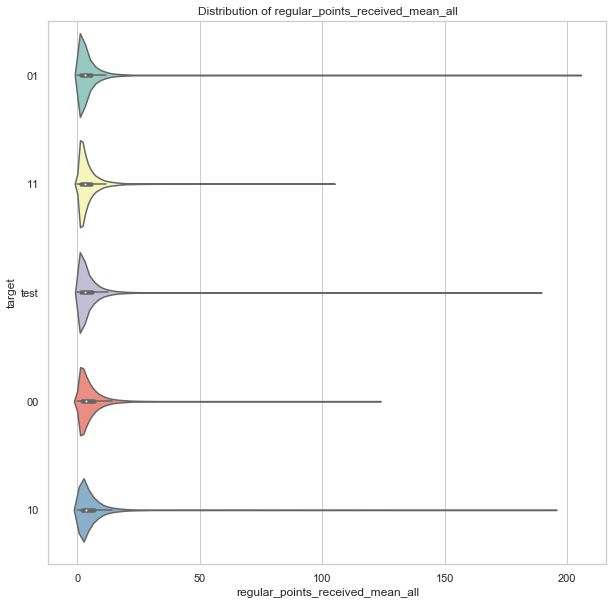

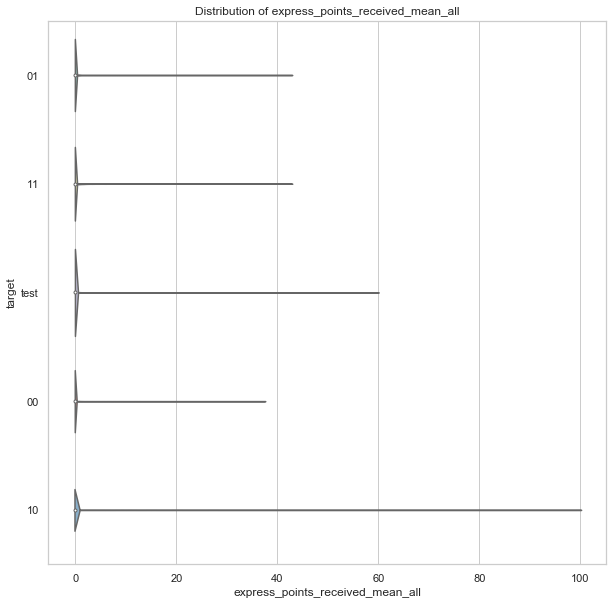

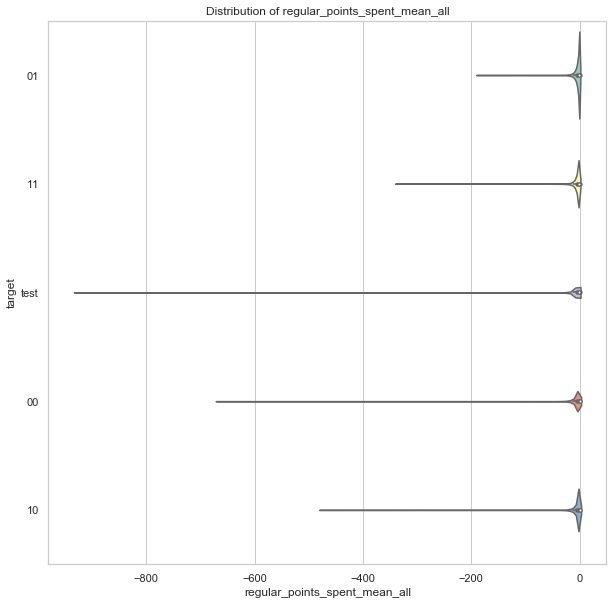

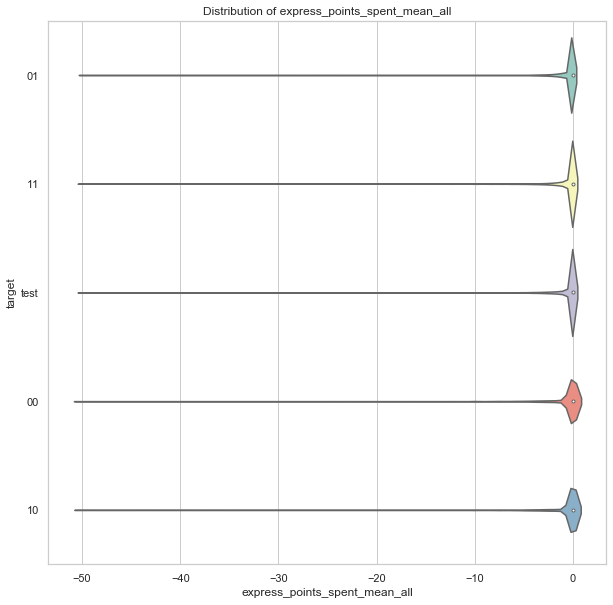

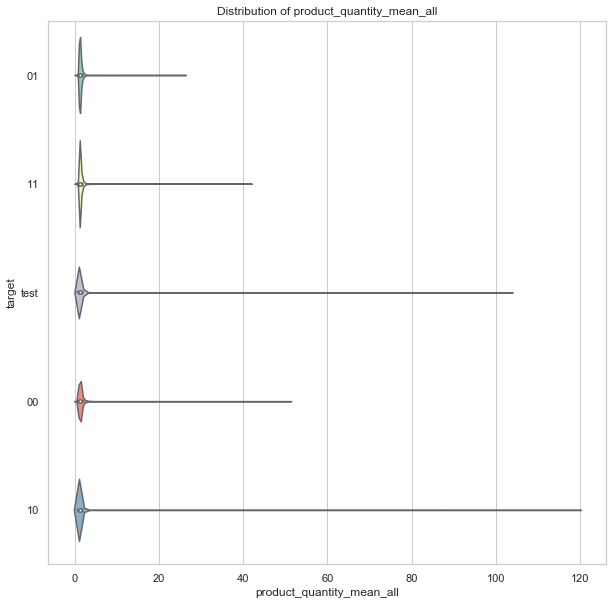

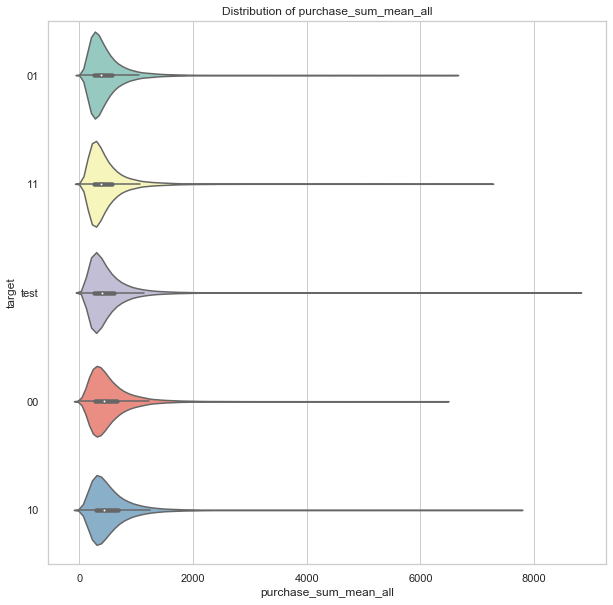

In [116]:
for feat in total_mean.columns:
    violin_for_aggr(feat)

count    400162.000000
mean          4.616274
std           6.103045
min           0.000000
25%           1.200000
50%           2.600000
75%           5.910833
max         276.500000
Name: regular_points_received_mean_last_month, dtype: float64
count    400162.000000
mean          0.005898
std           0.274583
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: express_points_received_mean_last_month, dtype: float64
count    400162.000000
mean         -3.698766
std          15.610535
min       -1136.000000
25%          -1.062500
50%           0.000000
75%           0.000000
max           0.000000
Name: regular_points_spent_mean_last_month, dtype: float64
count    400162.000000
mean         -0.693196
std           3.881198
min         -50.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.000000
Name: express_points_spent_mean_last_month, dtype: float64
count    400162.000000

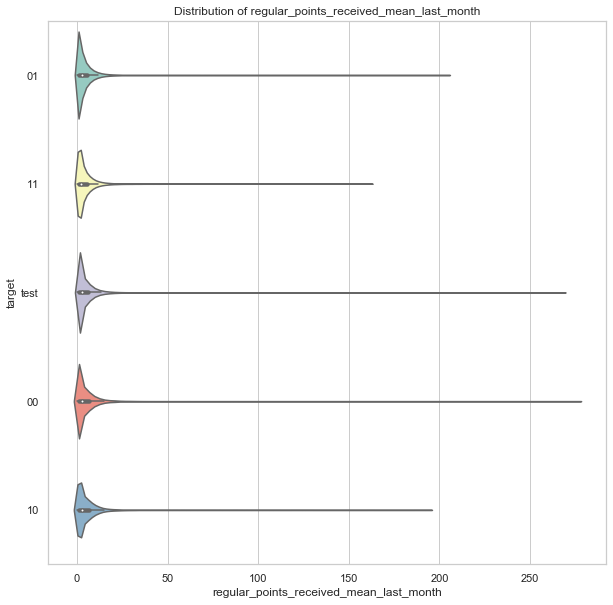

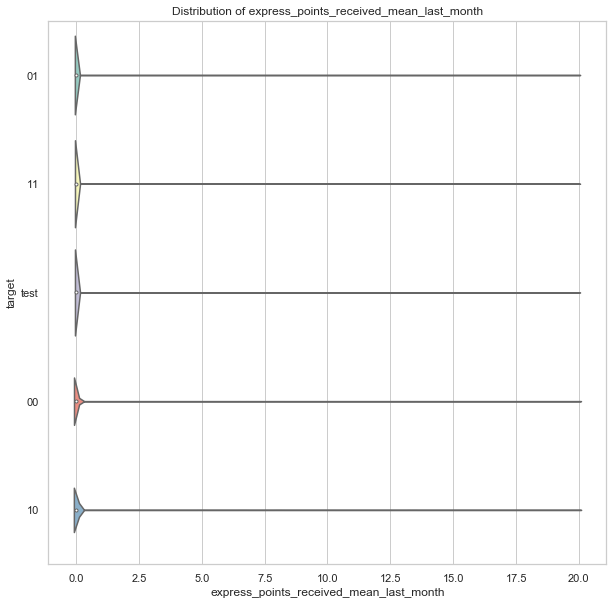

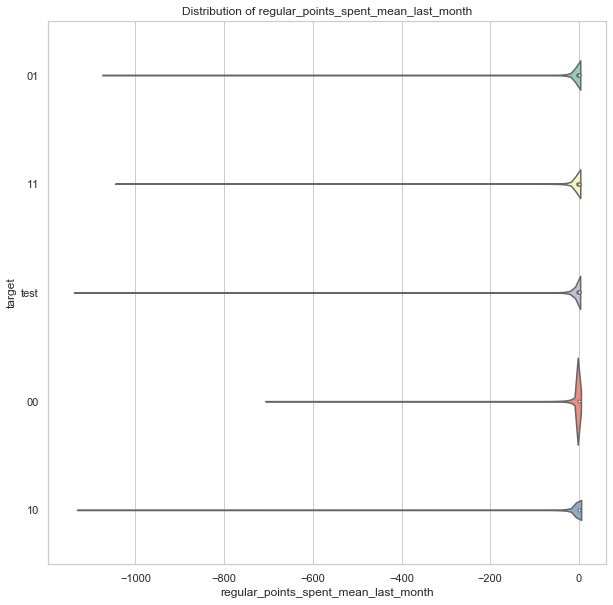

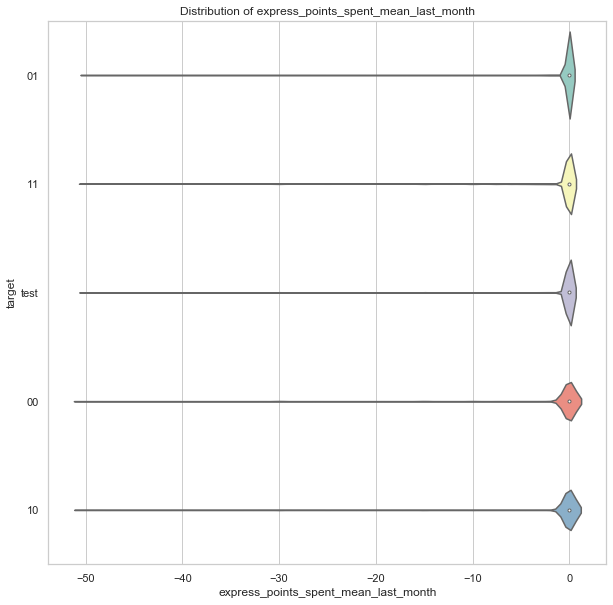

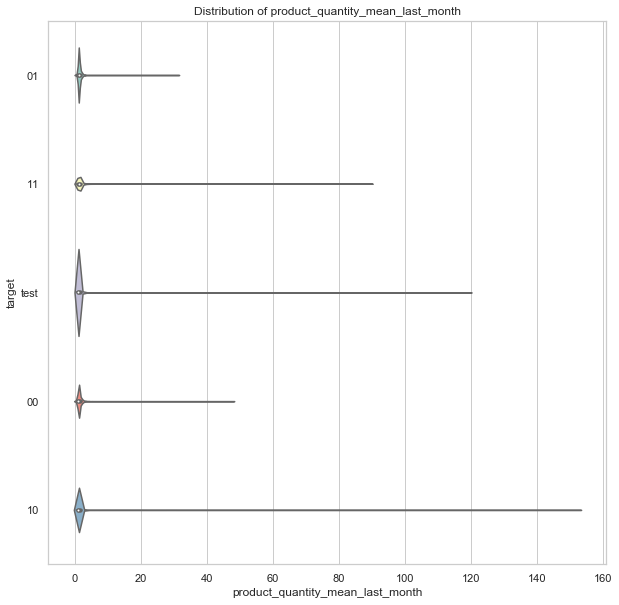

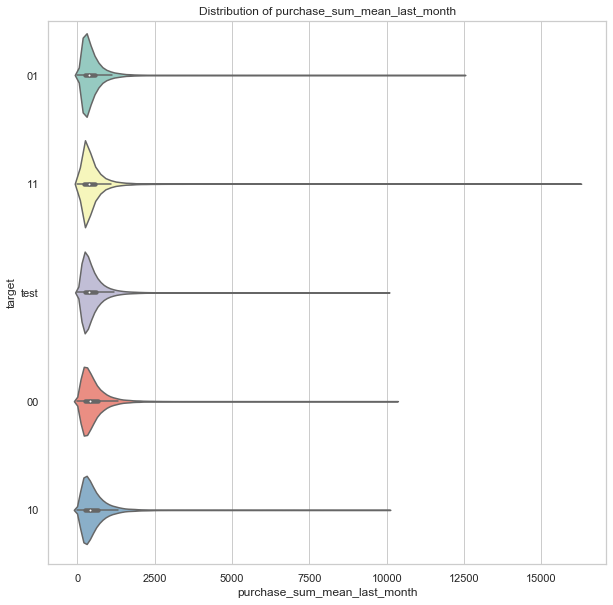

In [117]:
for feat in total_mean_last.columns:
    violin_for_aggr(feat)

### Std aggregative

In [118]:
total_std = all_time.groupby('client_id').std()
total_std_last = last_month.groupby('client_id').std()
total_std.columns = list(c+"_std_all" for c in inspected_columns)
total_std_last.columns = list(c+"_std_last_month" for c in inspected_columns)
total_std_last.sample()

regular_points_received_std_last_month  \
client_id                                            
cc03a84212                                1.176846   

            express_points_received_std_last_month  \
client_id                                            
cc03a84212                                     0.0   

            regular_points_spent_std_last_month  \
client_id                                         
cc03a84212                             5.192063   

            express_points_spent_std_last_month  \
client_id                                         
cc03a84212                                  0.0   

            product_quantity_std_last_month  purchase_sum_std_last_month  
client_id                                                                 
cc03a84212                         0.323381                   128.439148

In [119]:
aggr = pd.concat([aggr, total_std, total_std_last], axis=1).set_index(clients.df.index)
aggr.head(1)

trans_count_all  trans_count_last_month  \
client_id                                             
000012768d                4                       2   

            regular_points_received_sum_all  express_points_received_sum_all  \
client_id                                                                      
000012768d                        25.700001                              0.0   

            regular_points_spent_sum_all  express_points_spent_sum_all  \
client_id                                                                
000012768d                           0.0                           0.0   

            product_quantity_sum_all  purchase_sum_sum_all  \
client_id                                                    
000012768d                       4.0                2803.0   

            regular_points_received_sum_last_month  \
client_id                                            
000012768d                                    10.0   

            express_points_received_sum_last_month  \
client_id                                            
000012768d                                     0.0   

            regular_points_spent_sum_last_month  \
client_id                                         
000012768d                                  0.0   

            express_points_spent_sum_last_month  \
client_id                                         
000012768d                                  0.0   

            product_quantity_sum_last_month  purchase_sum_sum_last_month  \
client_id                                                                  
000012768d                              2.0                       1222.0   

            stores_visited_all  stores_visited_last_month target  \
client_id                                                          
000012768d                   3                          1     01   

            regular_points_received_mean_all  \
client_id                                      
000012768d                             6.425   

            express_points_received_mean_all  regular_points_spent_mean_all  \
client_id                                                                     
000012768d                               0.0                            0.0   

            express_points_spent_mean_all  product_quantity_mean_all  \
client_id                                                              
000012768d                            0.0                        1.0   

            purchase_sum_mean_all  regular_points_received_mean_last_month  \
client_id                                                                    
000012768d                 700.75                                      5.0   

            express_points_received_mean_last_month  \
client_id                                             
000012768d                                      0.0   

            regular_points_spent_mean_last_month  \
client_id                                          
000012768d                                   0.0   

            express_points_spent_mean_last_month  \
client_id                                          
000012768d                                   0.0   

            product_quantity_mean_last_month  purchase_sum_mean_last_month  \
client_id                                                                    
000012768d                               1.0                         611.0   

            regular_points_received_std_all  express_points_received_std_all  \
client_id                                                                      
000012768d                         3.433536                              0.0   

            regular_points_spent_std_all  express_points_spent_std_all  \
client_id                                                                
000012768d                           0.0                           0.0   

            product_quantity_std_all  purchase_sum_std_all  \
client_id                                          

count    392455.000000
mean          4.985476
std           5.789959
min           0.000000
25%           1.922714
50%           3.548239
75%           6.034510
max         409.642731
Name: regular_points_received_std_all, dtype: float64
count    392455.000000
mean          0.168725
std           1.751853
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         173.205078
Name: express_points_received_std_all, dtype: float64
count    392455.000000
mean         13.135375
std          22.345100
min           0.000000
25%           0.000000
50%           5.666667
75%          17.299326
max         681.866882
Name: regular_points_spent_std_all, dtype: float64
count    392455.000000
mean          1.584616
std           4.191852
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         106.066017
Name: express_points_spent_std_all, dtype: float64
count    392455.000000
mean          0.775845
std     

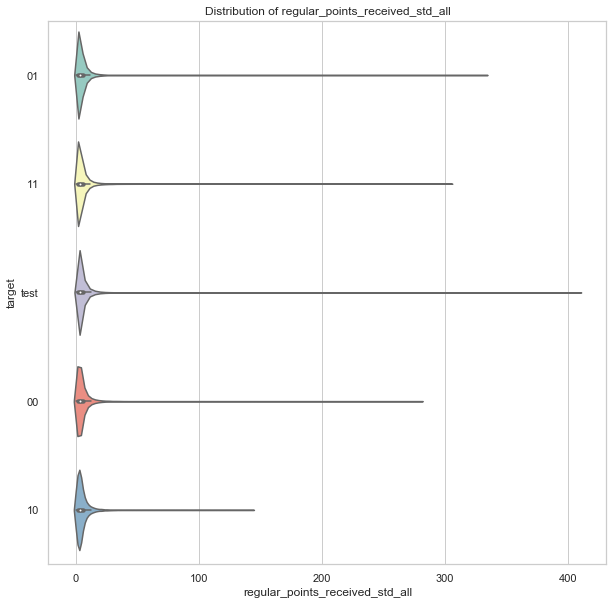

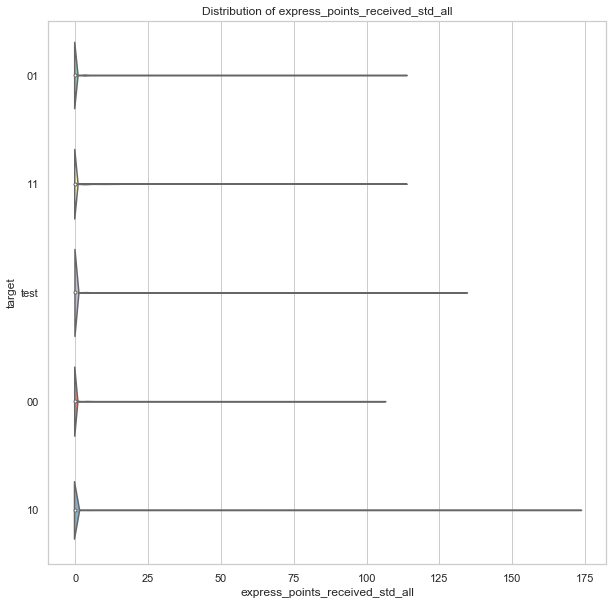

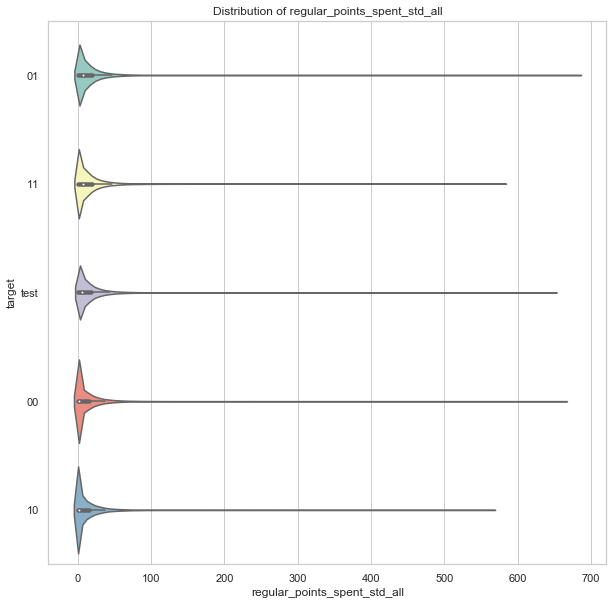

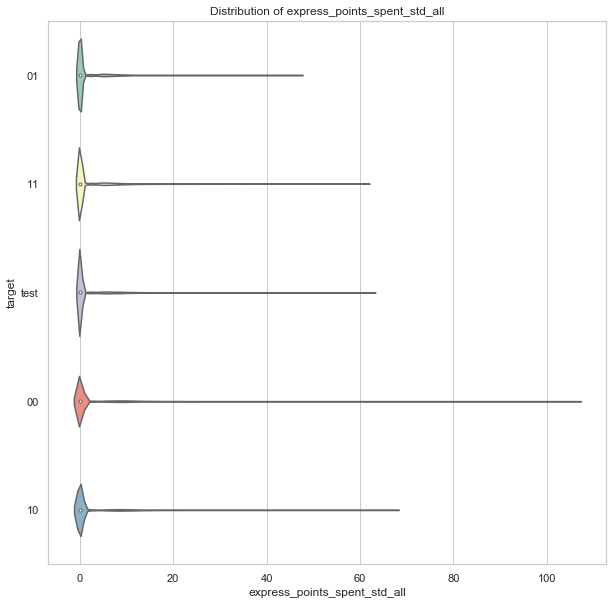

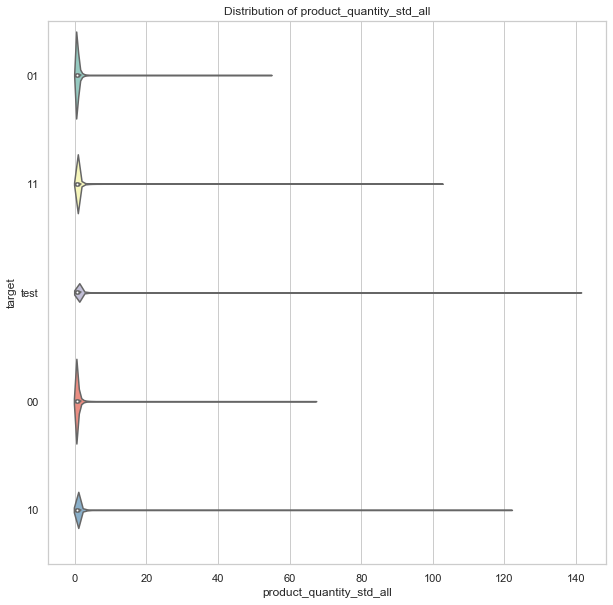

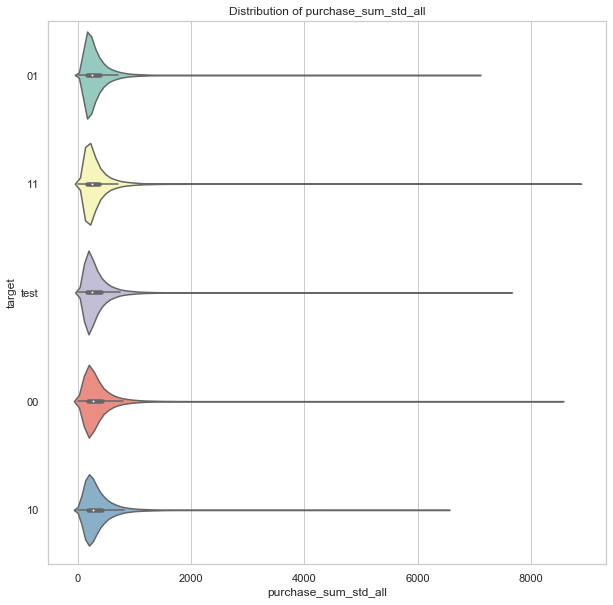

In [120]:
for feat in total_std.columns:
    violin_for_aggr(feat)

count    344638.000000
mean          3.797229
std           5.482990
min           0.000000
25%           0.707107
50%           2.571861
75%           4.723817
max         409.642731
Name: regular_points_received_std_last_month, dtype: float64
count    344638.000000
mean          0.012915
std           0.522636
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.284271
Name: express_points_received_std_last_month, dtype: float64
count    344638.000000
mean          7.817378
std          22.542259
min           0.000000
25%           0.000000
50%           0.000000
75%           5.028017
max         761.675598
Name: regular_points_spent_std_last_month, dtype: float64
count    344638.000000
mean          0.866706
std           3.753520
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          35.355339
Name: express_points_spent_std_last_month, dtype: float64
count    344638.000000
mea

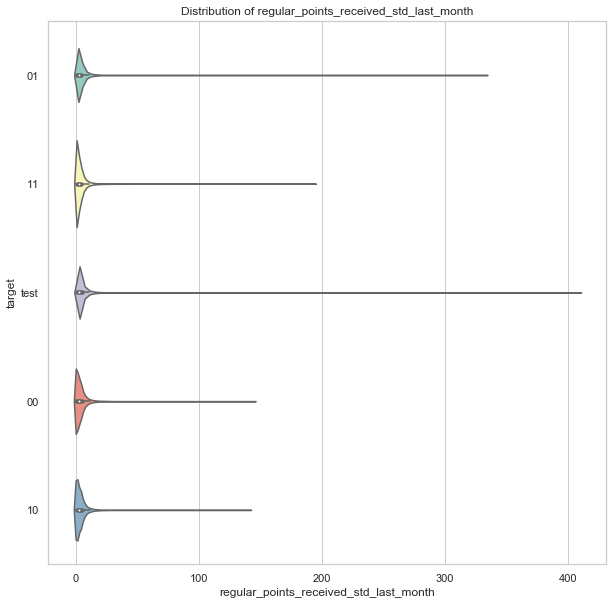

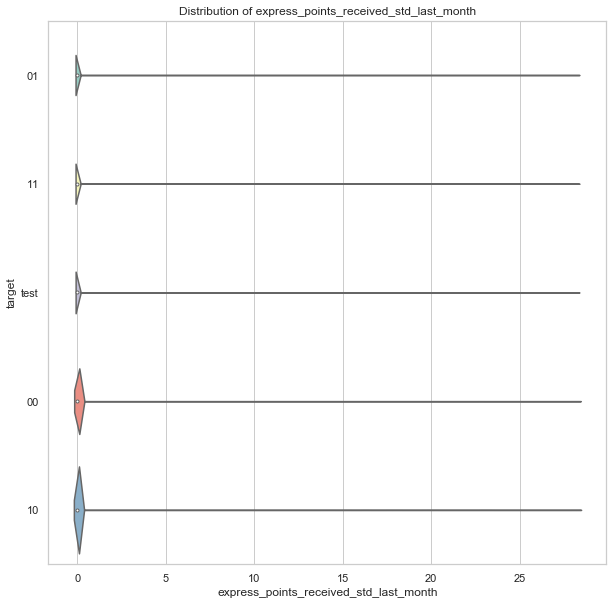

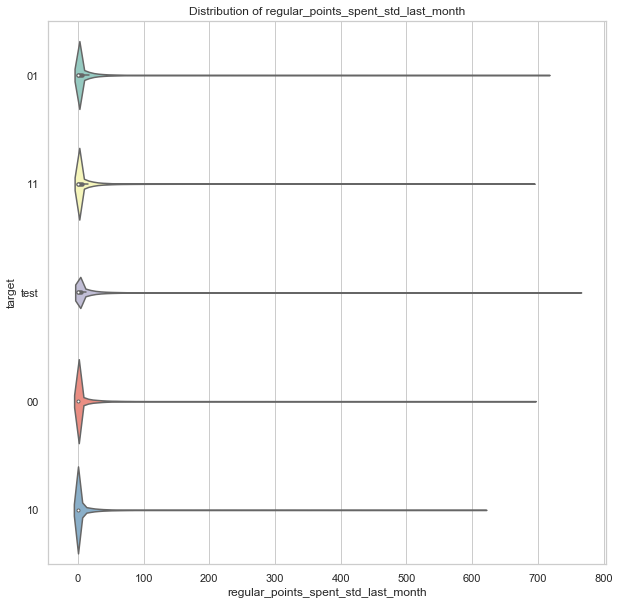

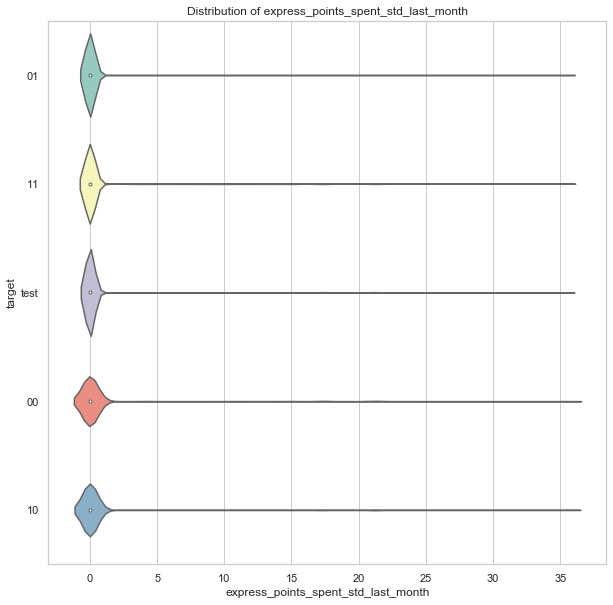

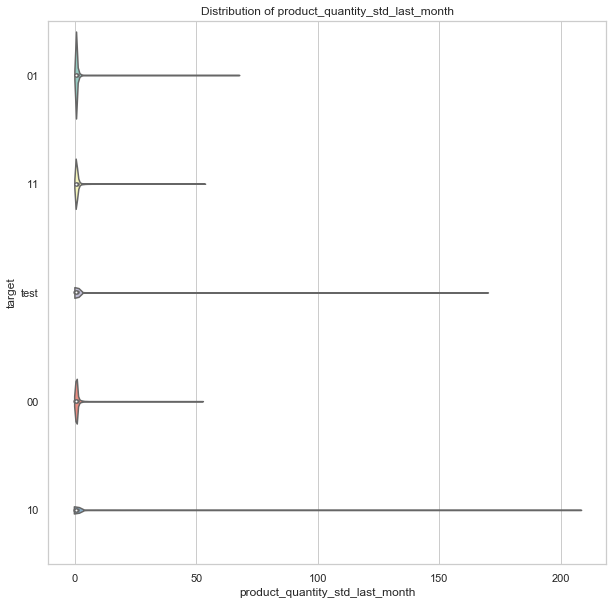

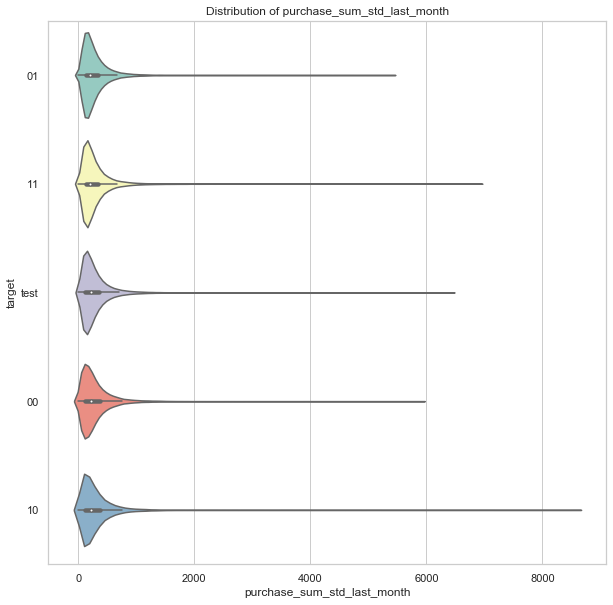

In [121]:
for feat in total_std_last.columns:
    violin_for_aggr(feat)

### Range aggregative

In [420]:
# Min
# total_min = all_time.groupby('client_id').min()
# total_min_last = last_month.groupby('client_id').min()
# total_min.columns = list(c+"_min_all" for c in inspected_columns)
# total_min_last.columns = list(c+"_min_last_month" for c in inspected_columns)
# # Max
# total_max = all_time.groupby('client_id').max()
# total_max_last = last_month.groupby('client_id').max()
# total_max.columns = list(c+"_max_all" for c in inspected_columns)
# total_max_last.columns = list(c+"_max_last_month" for c in inspected_columns)
# range
# total_range = total_min - total_range
# total_max.columns = list(c+"_range_all" for c in inspected_columns)
# total_range.sample()

## Ratio features

count    400162.000000
mean          0.352141
std           0.214485
min           0.007092
25%           0.214286
50%           0.294118
75%           0.416667
max           1.000000
Name: trans_count_ratio, dtype: float64


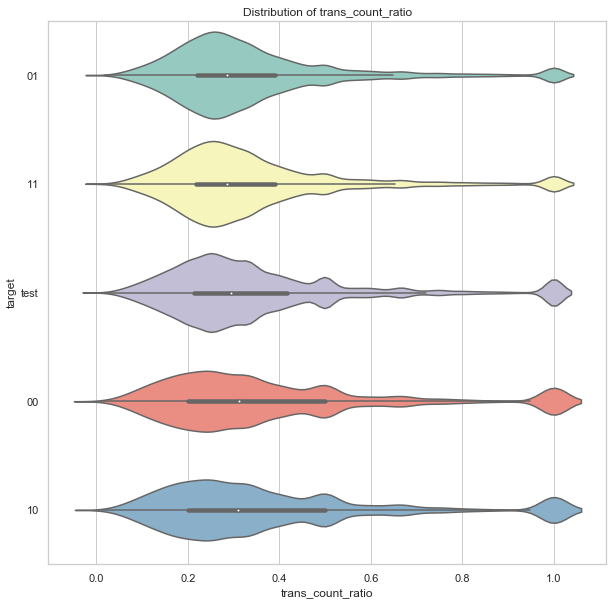

In [122]:
aggr['trans_count_ratio'] = aggr['trans_count_last_month'] / aggr['trans_count_all']
violin_for_aggr('trans_count_ratio')

count    400162.000000
mean          0.718442
std           0.270754
min           0.043478
25%           0.500000
50%           0.666667
75%           1.000000
max           1.000000
Name: store_visited_ratio, dtype: float64


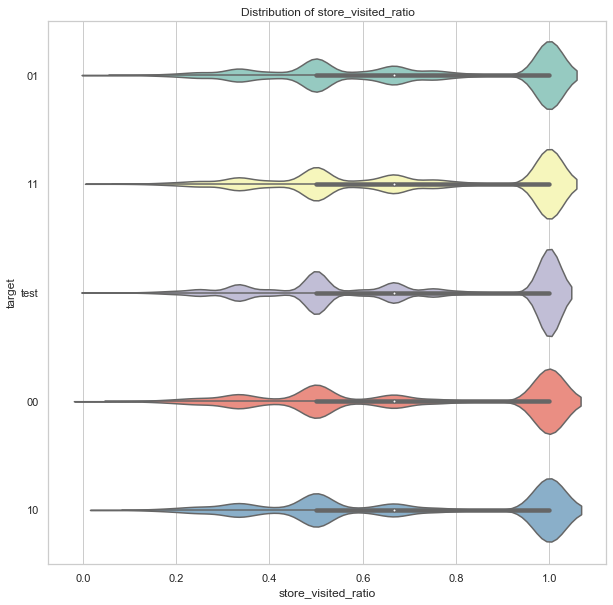

In [123]:
aggr['store_visited_ratio'] = aggr['stores_visited_last_month'] / aggr['stores_visited_all']
violin_for_aggr('store_visited_ratio')

### Sum ratio

count    399882.000000
mean          0.342188
std           0.256384
min           0.000000
25%           0.156495
50%           0.271908
75%           0.454039
max           1.000000
Name: regular_points_received_sum_ratio, dtype: float64


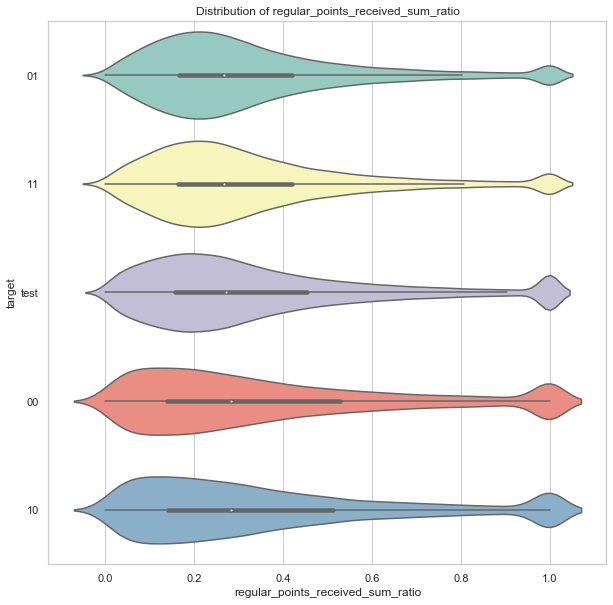

In [124]:
aggr['regular_points_received_sum_ratio'] = aggr['regular_points_received_sum_last_month']\
                                            / aggr['regular_points_received_sum_all']
violin_for_aggr('regular_points_received_sum_ratio')

count    399752.000000
mean          0.351488
std           0.228368
min           0.000000
25%           0.200000
50%           0.291667
75%           0.430556
max           1.000000
Name: product_quantity_sum_ratio, dtype: float64


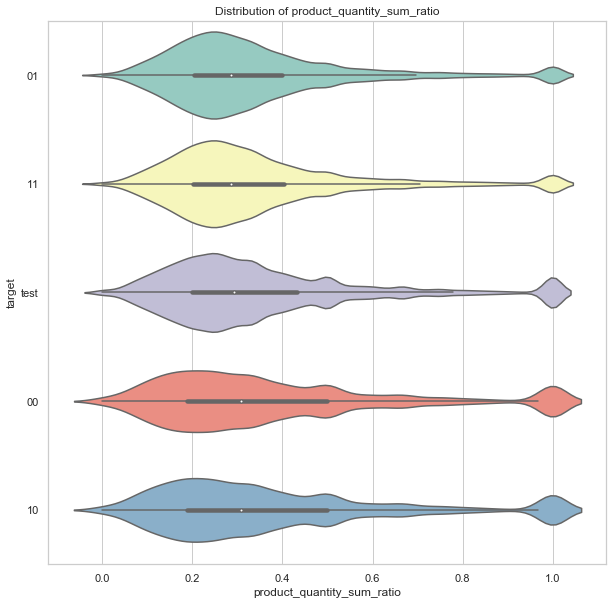

In [125]:
aggr['product_quantity_sum_ratio'] = aggr['product_quantity_sum_last_month']\
                                            / aggr['product_quantity_sum_all']
violin_for_aggr('product_quantity_sum_ratio')

count    400162.000000
mean          0.347704
std           0.229569
min           0.000179
25%           0.196256
50%           0.288755
75%           0.425997
max           1.000000
Name: purchase_sum_sum_ratio, dtype: float64


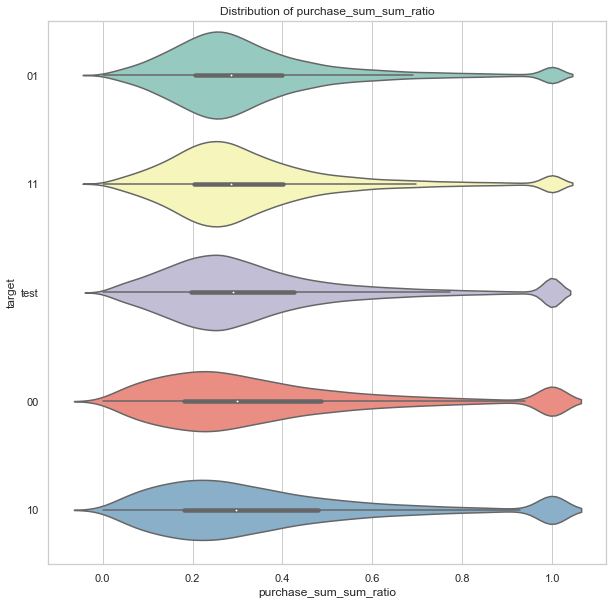

In [126]:
aggr['purchase_sum_sum_ratio'] = aggr['purchase_sum_sum_last_month']\
                                            / aggr['purchase_sum_sum_all']
violin_for_aggr('purchase_sum_sum_ratio')

### Mean ratio

count    399882.000000
mean          0.983689
std           0.576231
min           0.000000
25%           0.624776
50%           0.935731
75%           1.206522
max          17.664705
Name: regular_points_received_mean_ratio, dtype: float64


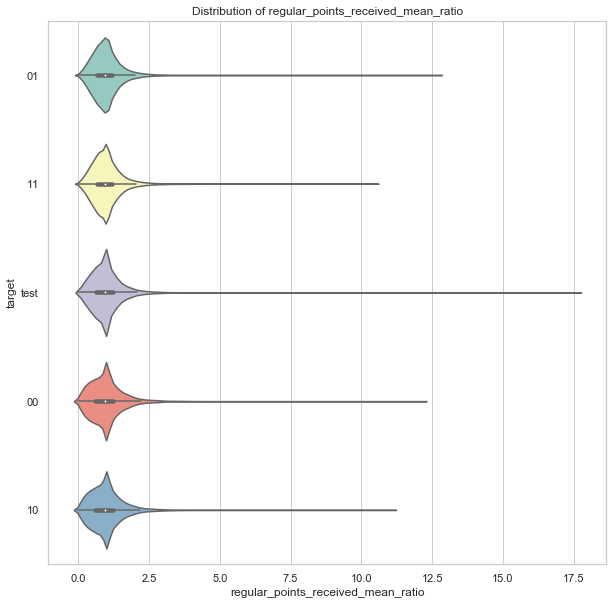

In [127]:
aggr['regular_points_received_mean_ratio'] = aggr['regular_points_received_mean_last_month']\
                                            / aggr['regular_points_received_mean_all']
violin_for_aggr('regular_points_received_mean_ratio')

count    399752.000000
mean          0.998668
std           0.289657
min           0.000000
25%           0.860215
50%           1.000000
75%           1.098039
max           8.750000
Name: product_quantity_mean_ratio, dtype: float64


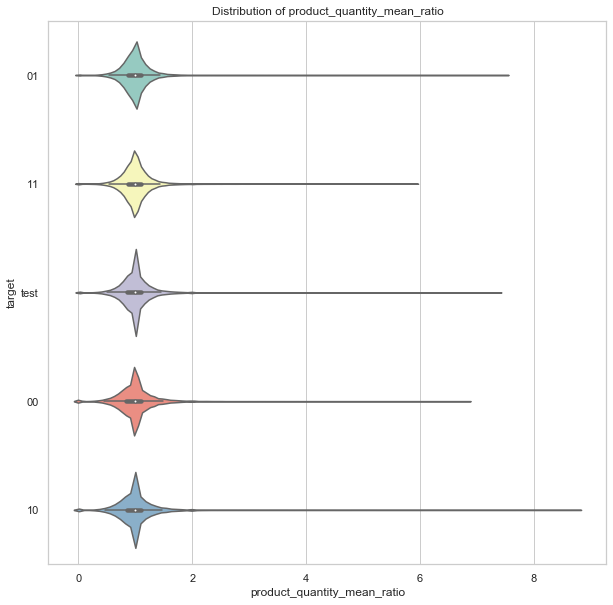

In [128]:
aggr['product_quantity_mean_ratio'] = aggr['product_quantity_mean_last_month']\
                                            / aggr['product_quantity_mean_all']
violin_for_aggr('product_quantity_mean_ratio')

count    400162.000000
mean          0.998267
std           0.353933
min           0.000800
25%           0.803792
50%           0.992762
75%           1.151712
max          11.607280
Name: purchase_sum_mean_ratio, dtype: float64


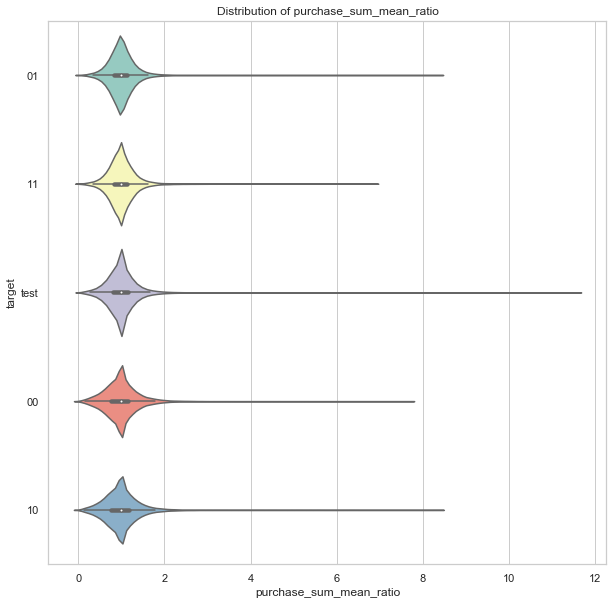

In [129]:
aggr['purchase_sum_mean_ratio'] = aggr['purchase_sum_mean_last_month'] / aggr['purchase_sum_mean_all']
violin_for_aggr('purchase_sum_mean_ratio')

### Std ratio

count    344502.000000
mean          0.818538
std           0.505895
min           0.000000
25%           0.378668
50%           0.830643
75%           1.161955
max           5.601050
Name: regular_points_received_std_ratio, dtype: float64


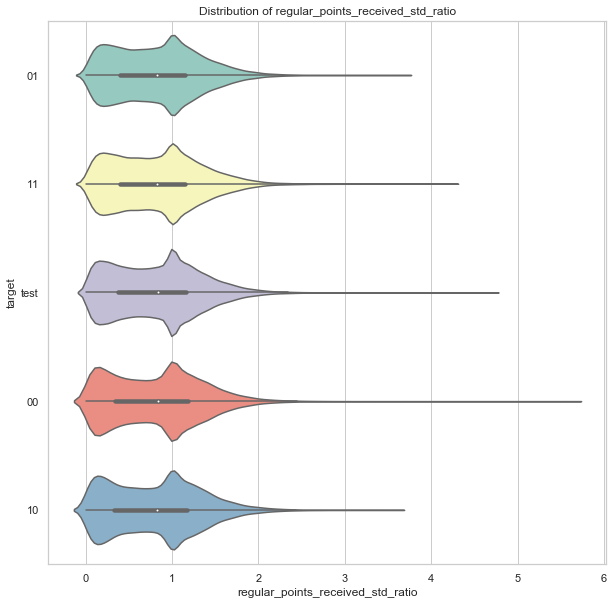

In [130]:
aggr['regular_points_received_std_ratio'] = aggr['regular_points_received_std_last_month']\
                                            / aggr['regular_points_received_std_all']
violin_for_aggr('regular_points_received_std_ratio')

count    320656.000000
mean          0.814625
std           0.579547
min           0.000000
25%           0.260983
50%           0.912469
75%           1.224745
max           4.358899
Name: product_quantity_std_ratio, dtype: float64


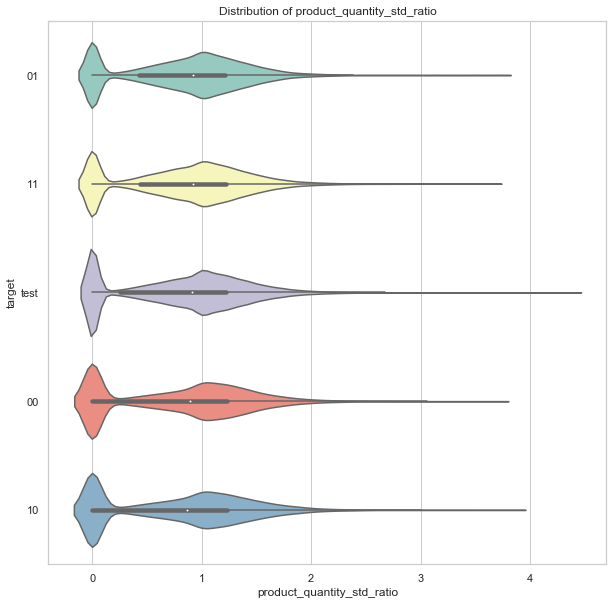

In [131]:
aggr['product_quantity_std_ratio'] = aggr['product_quantity_std_last_month']\
                                            / aggr['product_quantity_std_all']
violin_for_aggr('product_quantity_std_ratio')

count    344608.000000
mean          0.892707
std           0.398438
min           0.000000
25%           0.619097
50%           0.920603
75%           1.143466
max           4.374822
Name: purchase_sum_std_ratio, dtype: float64


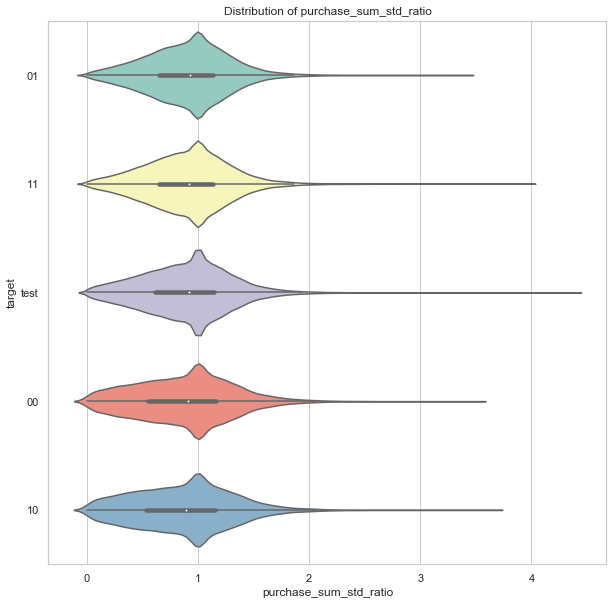

In [132]:
aggr['purchase_sum_std_ratio'] = aggr['purchase_sum_std_last_month'] / aggr['purchase_sum_std_all']
violin_for_aggr('purchase_sum_std_ratio')

## Another features

In [146]:
purch_per_store = purchases.df.groupby(['client_id', 'store_id'])[['purchase_sum']].nunique()
purch_per_store

purchase_sum
client_id  store_id                
000012768d 017c89b915             2
           54a4a11a29             1
           ed8d2683fd             1
000036f903 116ef2dfce             1
           3c6c3b17f2             4
...                             ...
ffffeb5619 7c1d114de1             1
           b77dc8c2a3             6
fffff6ce77 5ec64bdccb            18
           6e4faad02e            13
           e9fee9fe2b             1

[1169844 rows x 1 columns]

In [168]:
aggr['mean_purchase_on_stores'] = purch_per_store.groupby('client_id').mean()
aggr['std_purchase_on_stores'] = purch_per_store.groupby('client_id').std()
aggr['max_purchase_on_stores'] = purch_per_store.groupby('client_id').max()
aggr['min_purchase_on_stores'] = purch_per_store.groupby('client_id').min()

In [169]:
aggr.head(3)

trans_count_all  trans_count_last_month  \
client_id                                             
000012768d                4                       2   
000036f903               32                       8   
000048b7a6                8                       1   

            regular_points_received_sum_all  express_points_received_sum_all  \
client_id                                                                      
000012768d                        25.700001                              0.0   
000036f903                        54.900002                             60.0   
000048b7a6                        26.500000                              0.0   

            regular_points_spent_sum_all  express_points_spent_sum_all  \
client_id                                                                
000012768d                           0.0                           0.0   
000036f903                           0.0                           0.0   
000048b7a6                           0.0                           0.0   

            product_quantity_sum_all  purchase_sum_sum_all  \
client_id                                                    
000012768d                       4.0                2803.0   
000036f903                      32.0                9805.0   
000048b7a6                      11.0                3772.0   

            regular_points_received_sum_last_month  \
client_id                                            
000012768d                                    10.0   
000036f903                                    13.7   
000048b7a6                                     1.2   

            express_points_received_sum_last_month  \
client_id                                            
000012768d                                     0.0   
000036f903                                     0.0   
000048b7a6                                     0.0   

            regular_points_spent_sum_last_month  \
client_id                                         
000012768d                                  0.0   
000036f903                                  0.0   
000048b7a6                                  0.0   

            express_points_spent_sum_last_month  \
client_id                                         
000012768d                                  0.0   
000036f903                                  0.0   
000048b7a6                                  0.0   

            product_quantity_sum_last_month  purchase_sum_sum_last_month  \
client_id                                                                  
000012768d                              2.0                       1222.0   
000036f903                              8.0                       2784.0   
000048b7a6                              2.0                        342.0   

            stores_visited_all  stores_visited_last_month target  \
client_id                                                          
000012768d                   3                          1     01   
000036f903                   5                          4     11   
000048b7a6                   2                          1   test   

            regular_points_received_mean_all  \
client_id                                      
000012768d                          6.425000   
000036f903                          1.715625   
000048b7a6                          3.312500   

            express_points_received_mean_all  regular_points_spent_mean_all  \
client_id                                                                     
000012768d                             0.000                            0.0   
000036f903                             1.875                            0.0   
000048b7a6                             0.000                            0.0   

            express_points_spent_mean_all  product_quantity_mean_all  \
client_id                                                              
000012768d                            0.0                      1.000   
000036f903              

count    400162.000000
mean          8.580391
std           9.228641
min           1.000000
25%           3.000000
50%           5.666667
75%          10.500000
max         250.000000
Name: mean_purchase_on_stores, dtype: float64


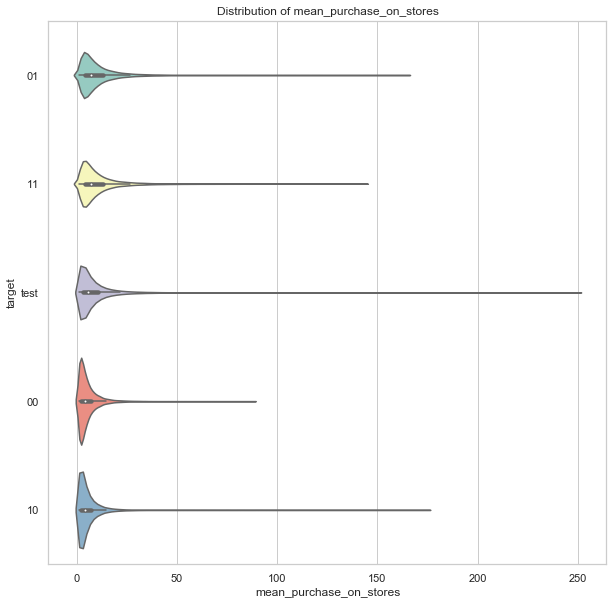

In [163]:
violin_for_aggr('mean_purchase_on_stores')

count    300054.000000
mean          7.262046
std           7.932155
min           0.000000
25%           2.121320
50%           4.827007
75%           9.668309
max         144.337567
Name: std_purchase_on_stores, dtype: float64


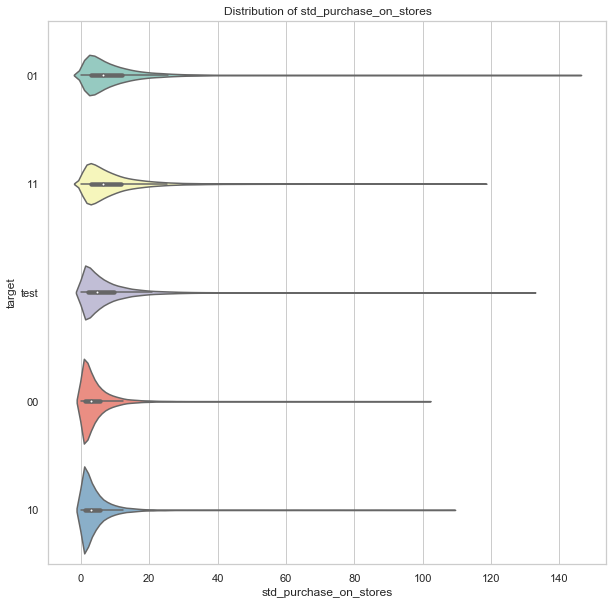

In [165]:
violin_for_aggr('std_purchase_on_stores')

count    400162.000000
mean         14.724719
std          13.904227
min           1.000000
25%           5.000000
50%          11.000000
75%          20.000000
max         252.000000
Name: max_purchase_on_stores, dtype: float64


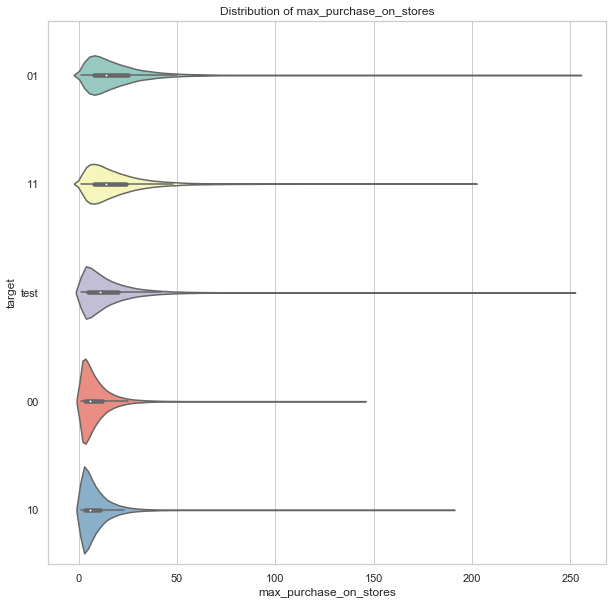

In [167]:
violin_for_aggr('max_purchase_on_stores')

count    400162.000000
mean          4.832753
std           9.004789
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         250.000000
Name: min_purchase_on_stores, dtype: float64


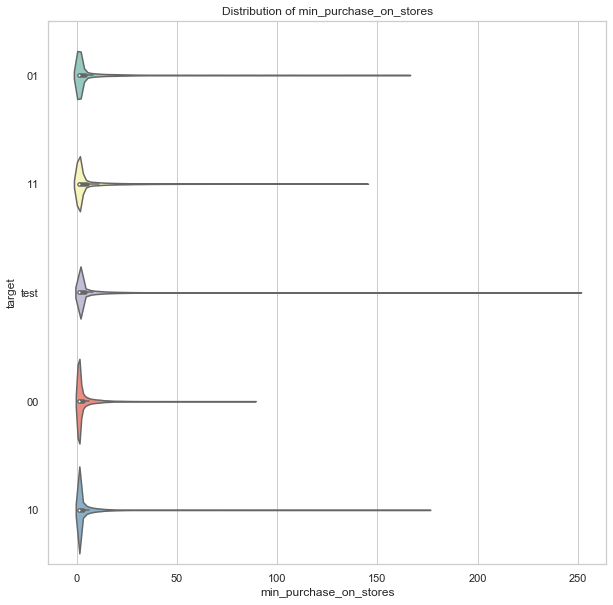

In [170]:
violin_for_aggr('min_purchase_on_stores')

In [173]:
aggr.isna().sum(axis=0)

trans_count_all                                 0
trans_count_last_month                          0
regular_points_received_sum_all                 0
express_points_received_sum_all                 0
regular_points_spent_sum_all                    0
express_points_spent_sum_all                    0
product_quantity_sum_all                        0
purchase_sum_sum_all                            0
regular_points_received_sum_last_month          0
express_points_received_sum_last_month          0
regular_points_spent_sum_last_month             0
express_points_spent_sum_last_month             0
product_quantity_sum_last_month                 0
purchase_sum_sum_last_month                     0
stores_visited_all                              0
stores_visited_last_month                       0
target                                          0
regular_points_received_mean_all                0
express_points_received_mean_all                0
regular_points_spent_mean_all                   0


In [176]:
aggr.drop([i for i in aggr.columns if i.find("std") != -1], inplace=True, axis=1)

In [177]:
aggr.isna().sum(axis=0)

trans_count_all                              0
trans_count_last_month                       0
regular_points_received_sum_all              0
express_points_received_sum_all              0
regular_points_spent_sum_all                 0
express_points_spent_sum_all                 0
product_quantity_sum_all                     0
purchase_sum_sum_all                         0
regular_points_received_sum_last_month       0
express_points_received_sum_last_month       0
regular_points_spent_sum_last_month          0
express_points_spent_sum_last_month          0
product_quantity_sum_last_month              0
purchase_sum_sum_last_month                  0
stores_visited_all                           0
stores_visited_last_month                    0
target                                       0
regular_points_received_mean_all             0
express_points_received_mean_all             0
regular_points_spent_mean_all                0
express_points_spent_mean_all                0
product_quant

In [192]:
aggr.fillna(0, inplace=True)

In [194]:
aggr.to_pickle(os.path.join(PATH_TO_DATA, 'features.pkl'))